In [1]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path
import sys

sys.path.insert(0, "..")

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import RandomCrop, ToPILImage
from torchvision.transforms.functional import crop
from tqdm import tqdm
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
)
from datasets import load_metric

from dataloader.dataset.container_dataset import ContainerOCRDatasetText

/Users/babi/miniforge3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/var/folders/j2/6f271mq965q51gvfpckpl6pw0000gn/T/ipykernel_9728/1900864360.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


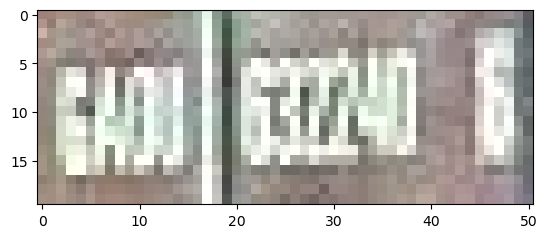

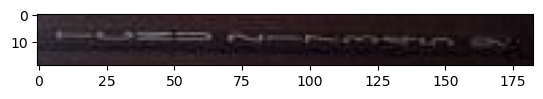

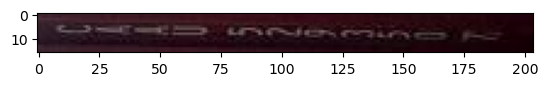

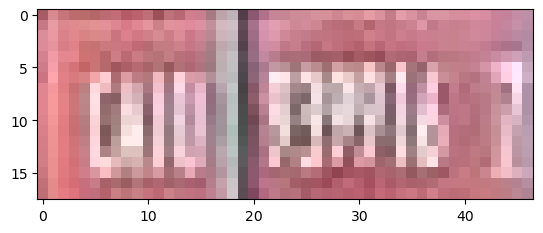

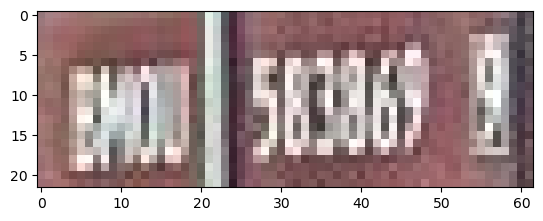

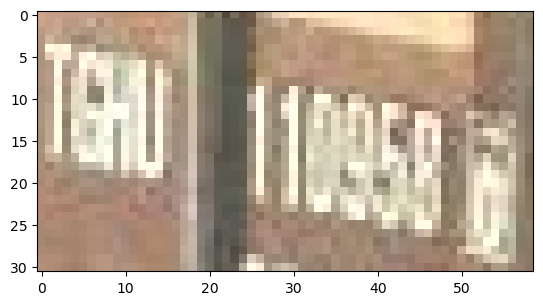

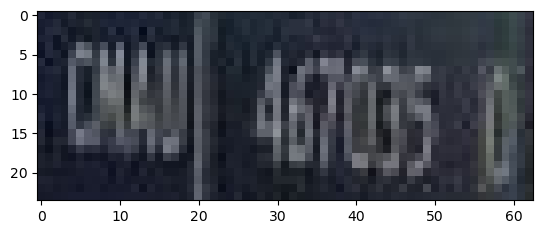

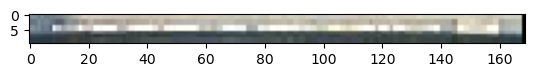

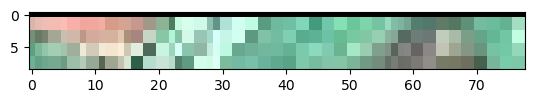

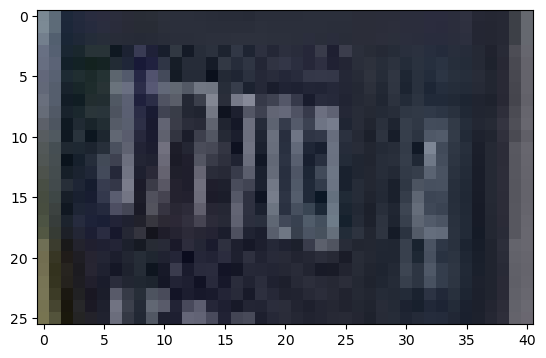

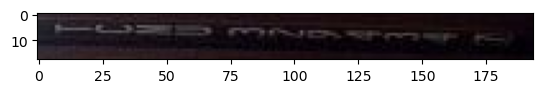

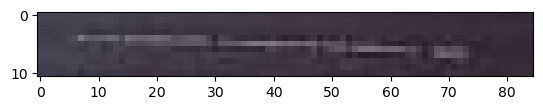

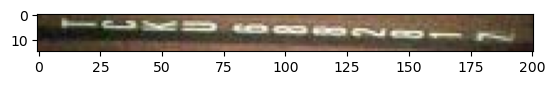

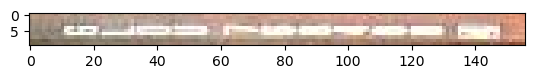

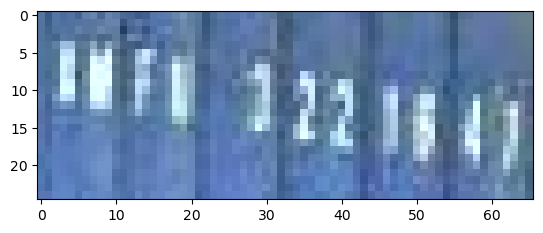

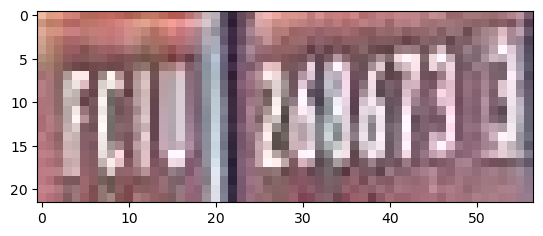

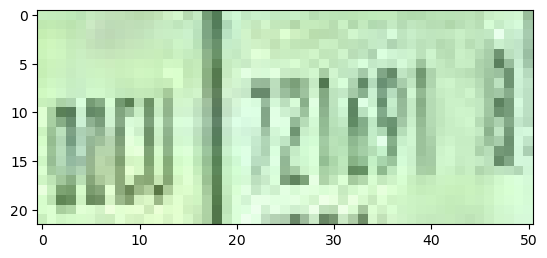

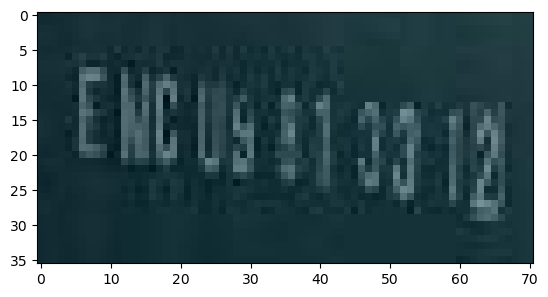

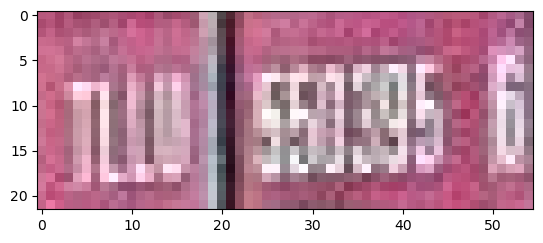

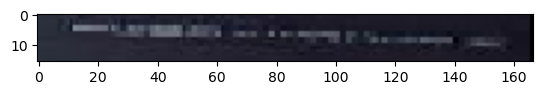

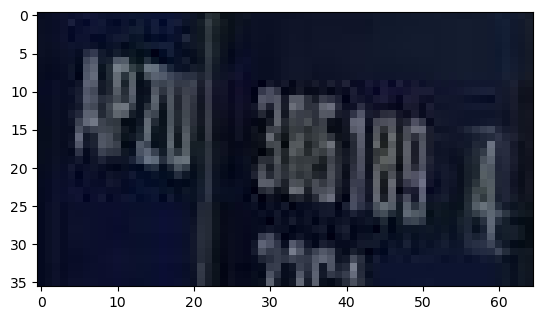

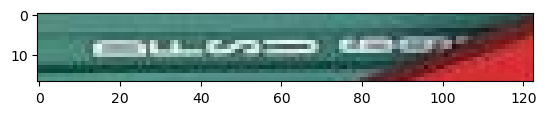

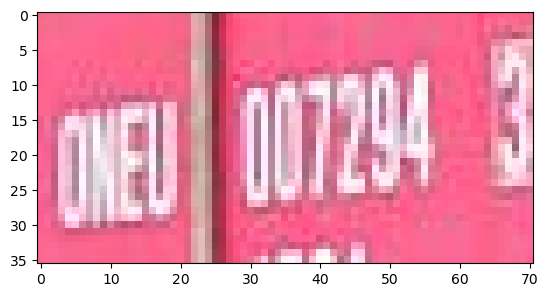

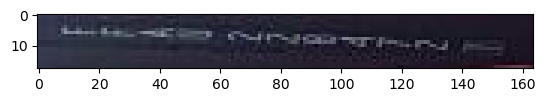

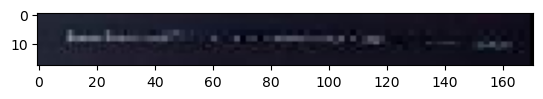

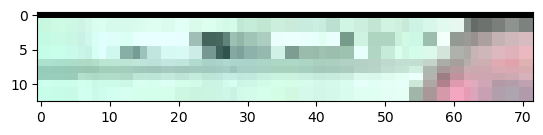

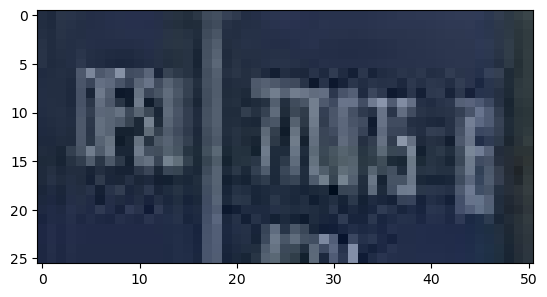

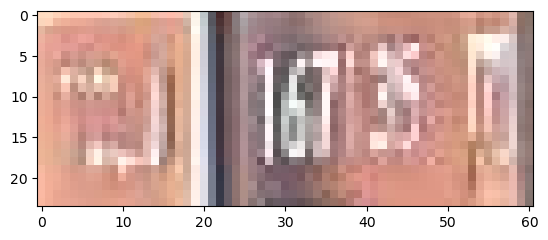

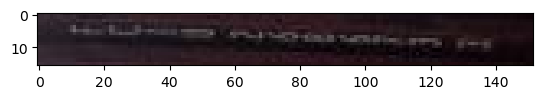

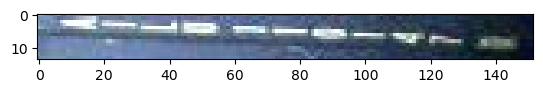

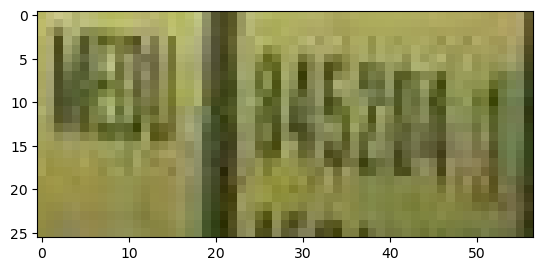

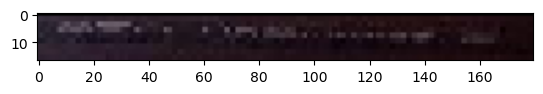

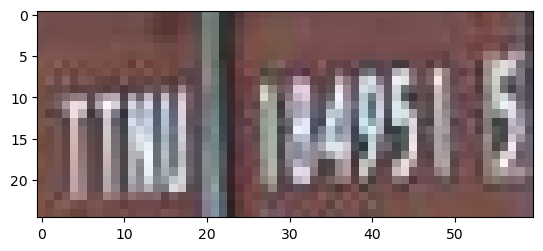

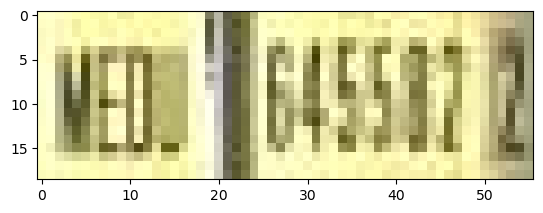

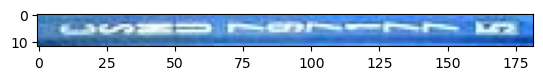

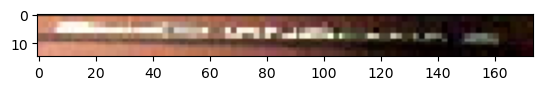

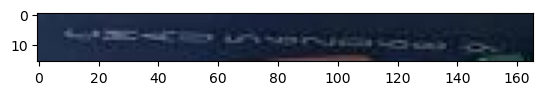

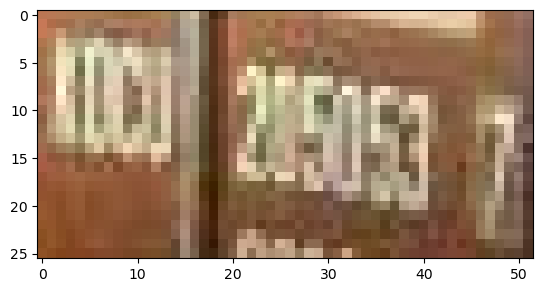

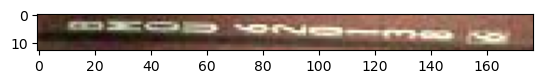

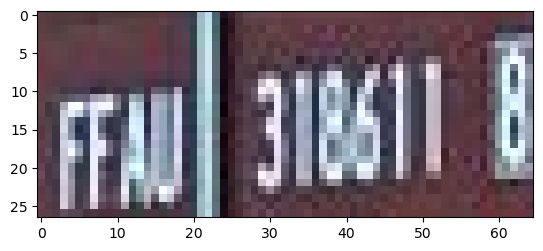

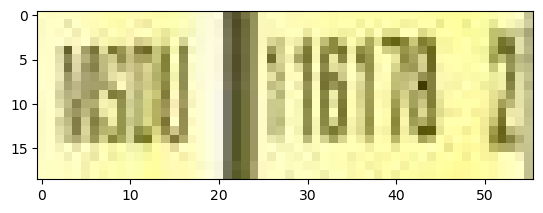

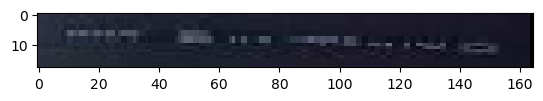

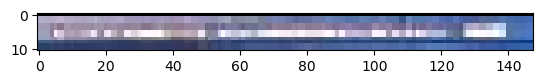

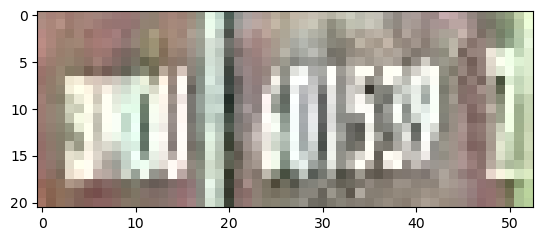

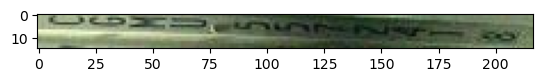

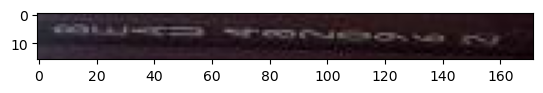

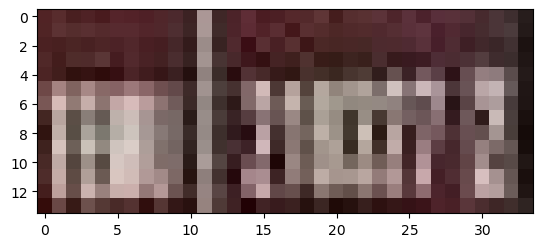

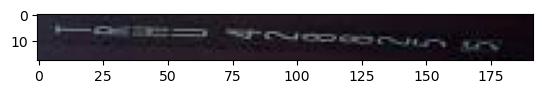

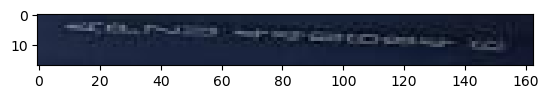

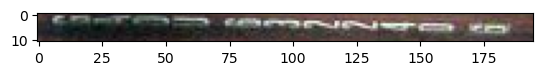

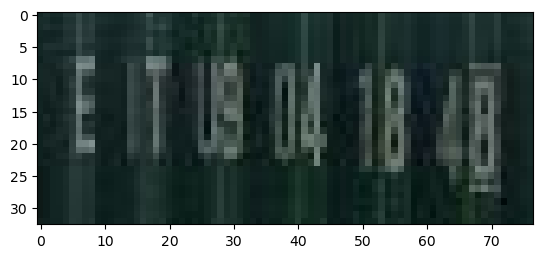

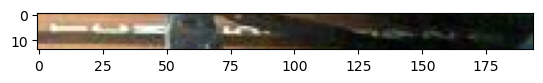

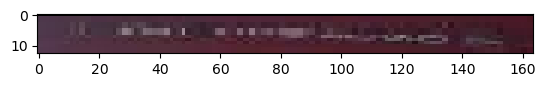

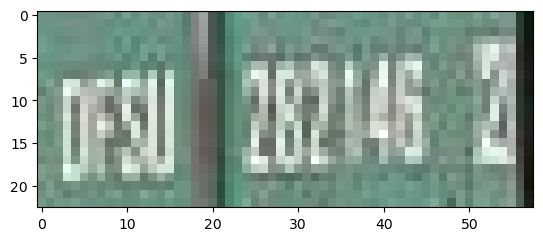

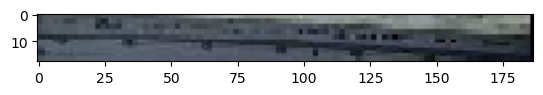

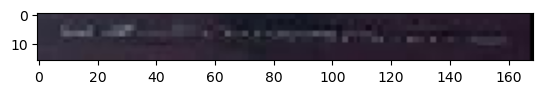

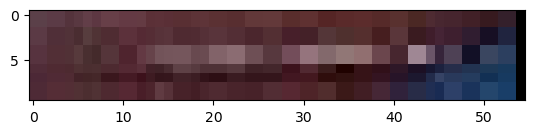

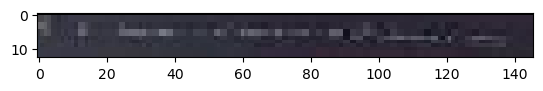

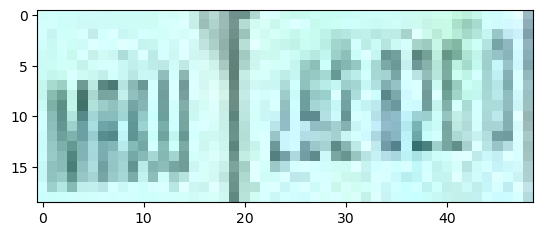

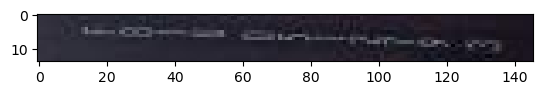

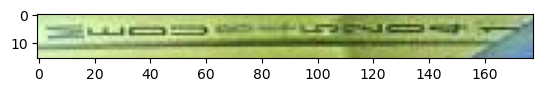

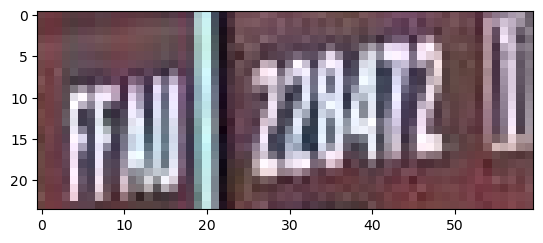

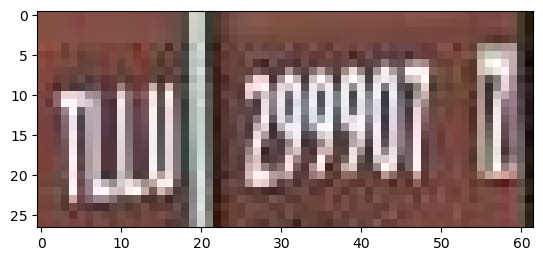

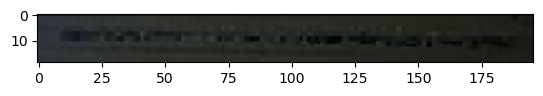

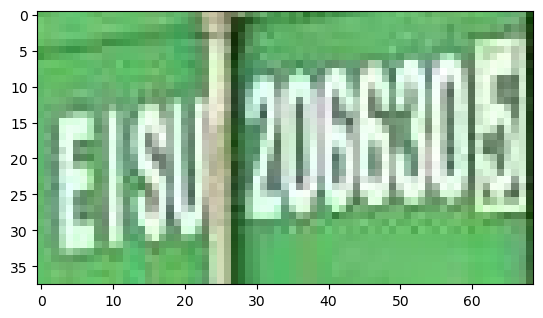

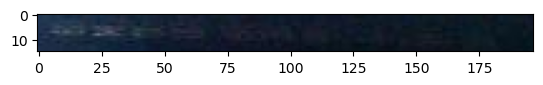

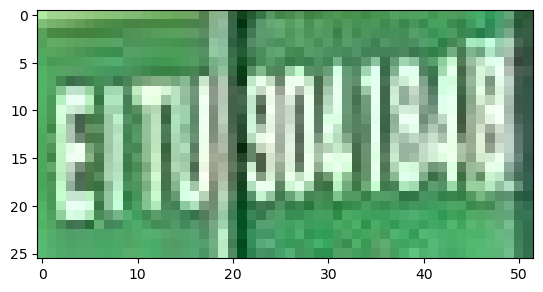

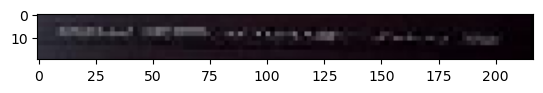

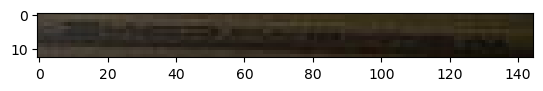

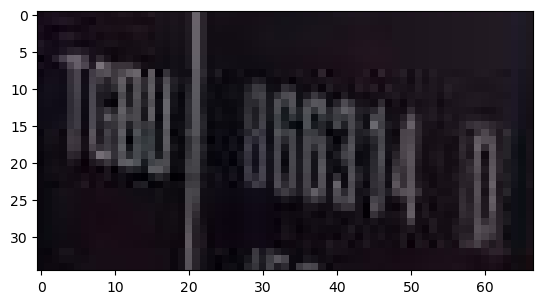

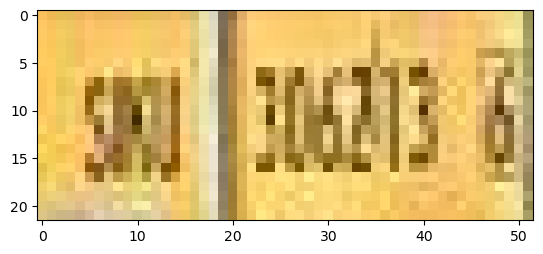

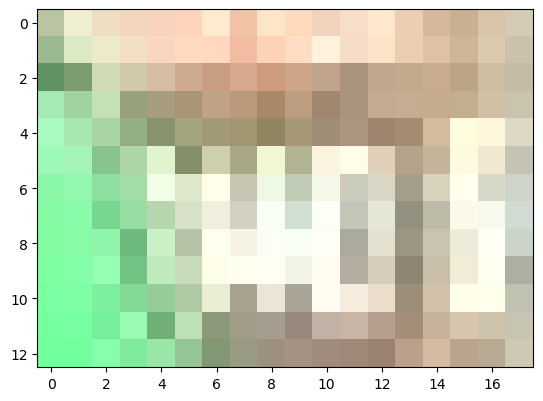

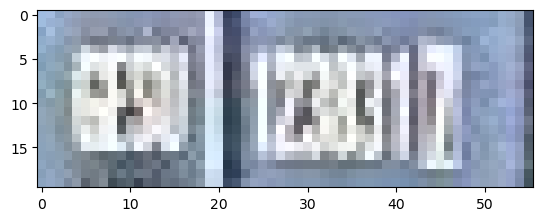

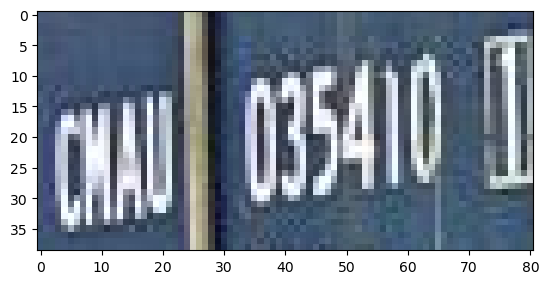

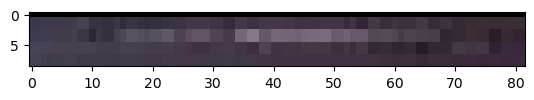

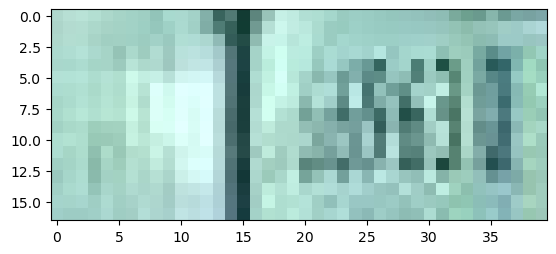

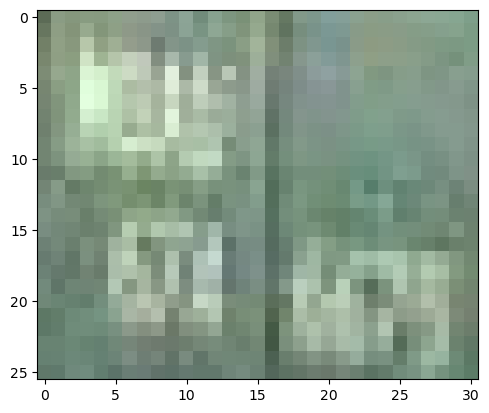

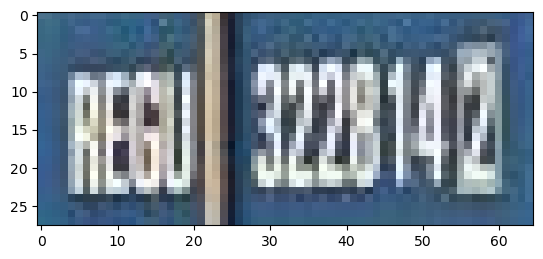

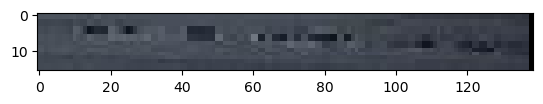

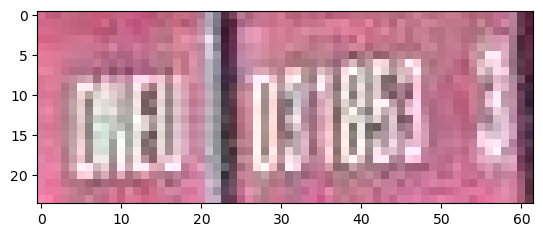

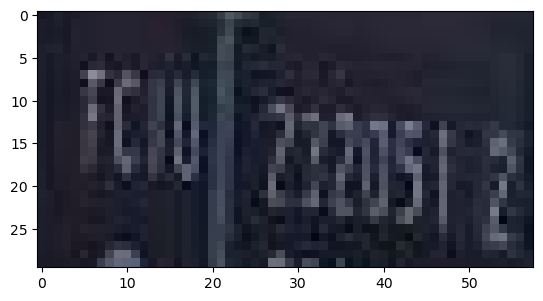

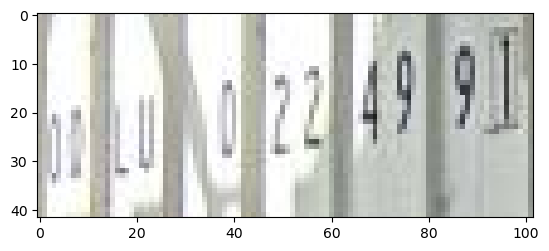

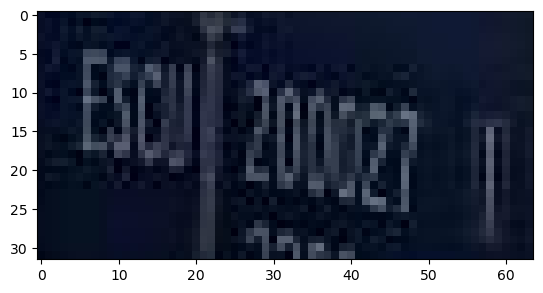

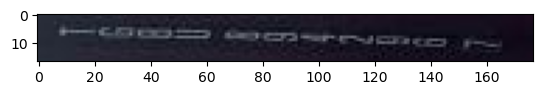

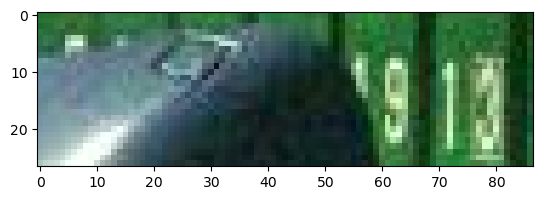

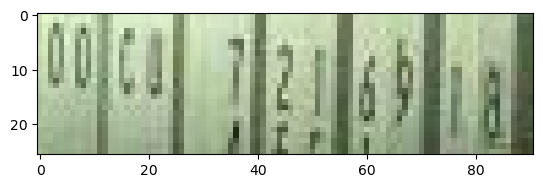

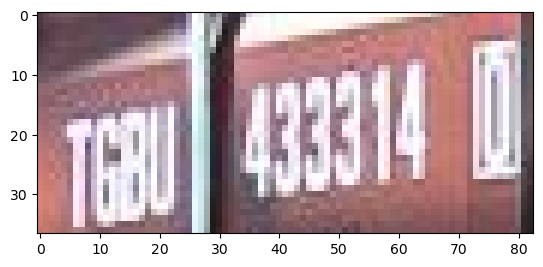

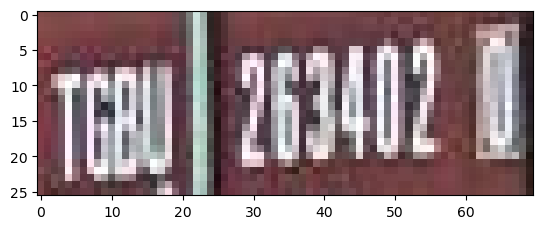

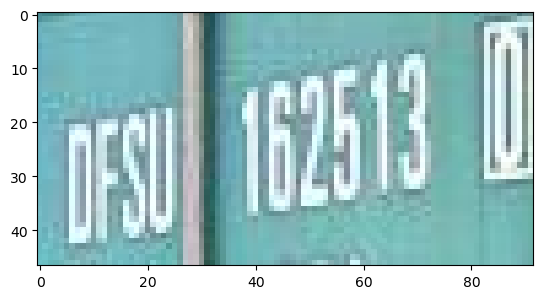

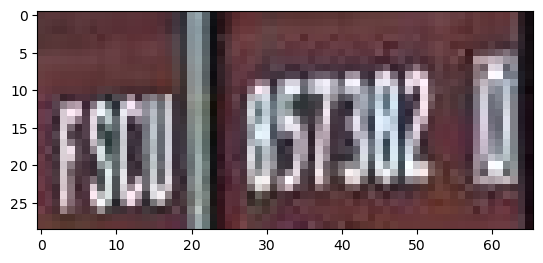

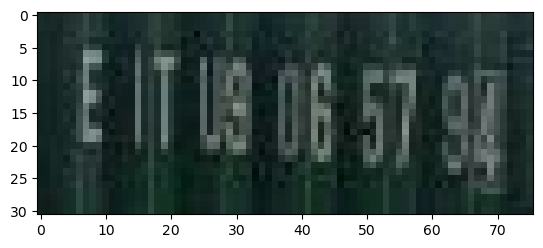

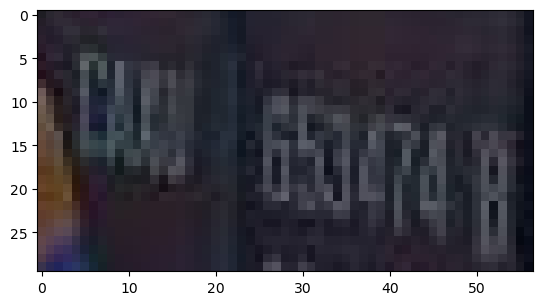

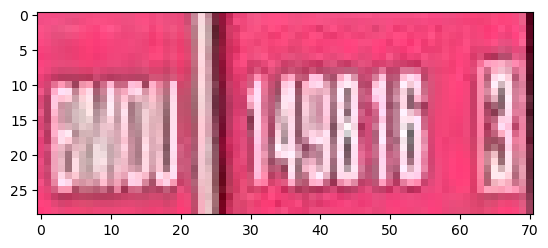

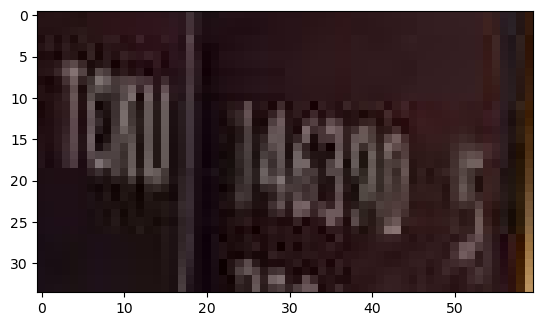

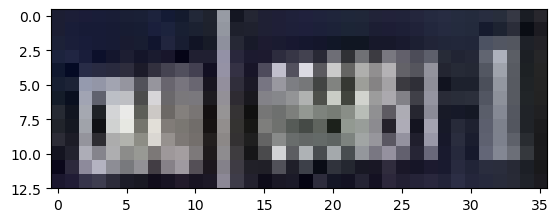

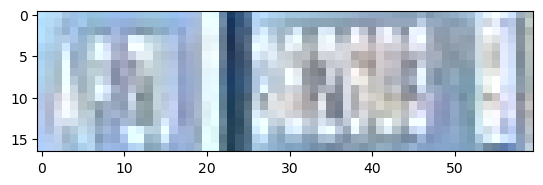

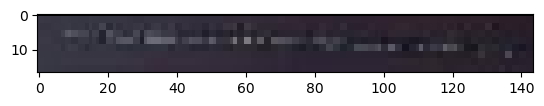

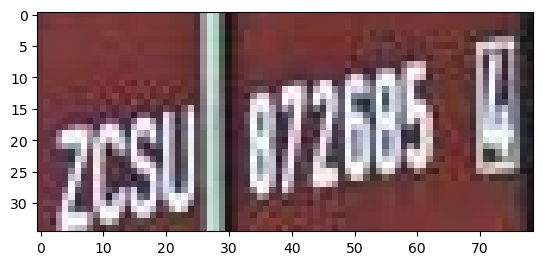

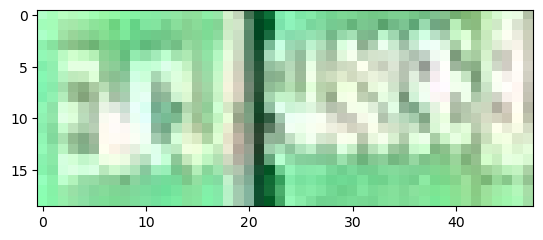

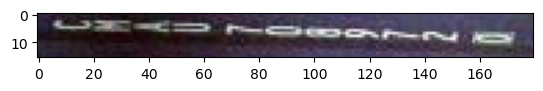

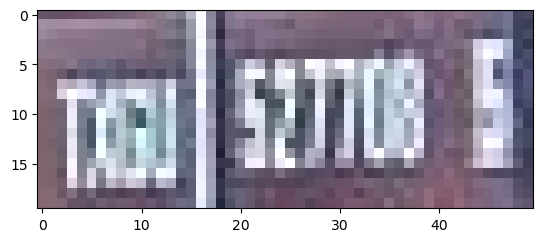

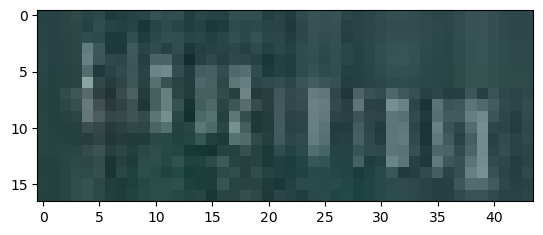

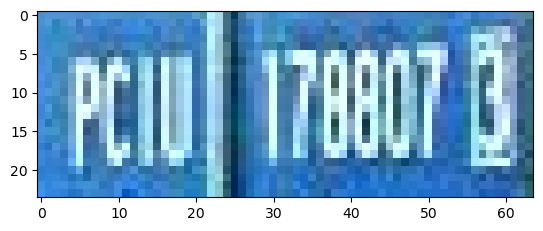

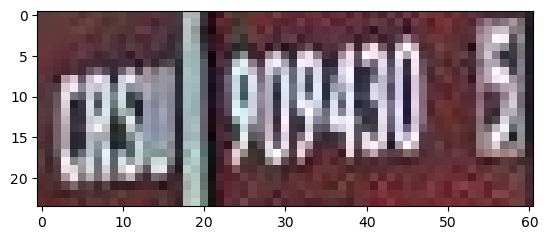

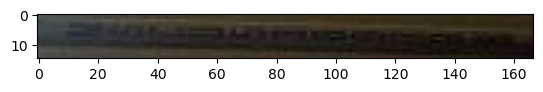

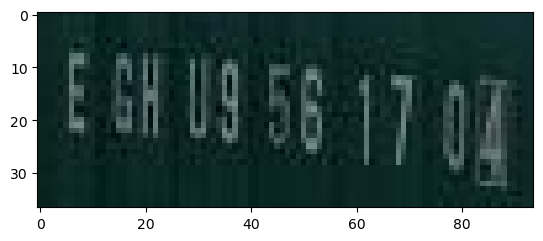

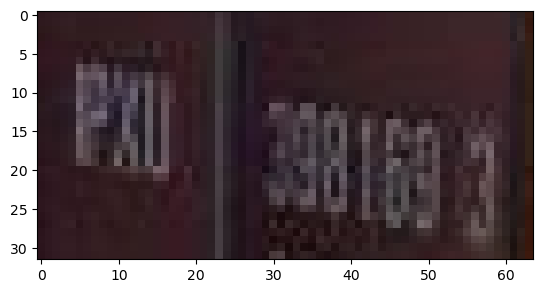

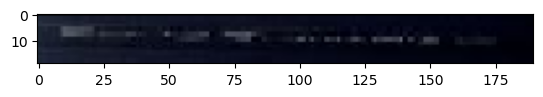

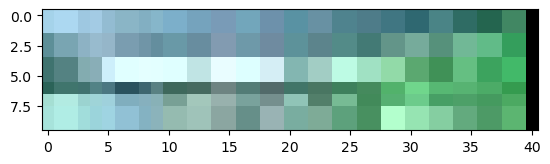

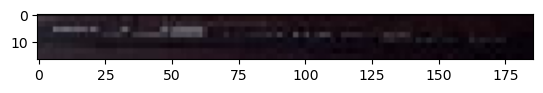

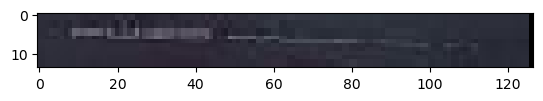

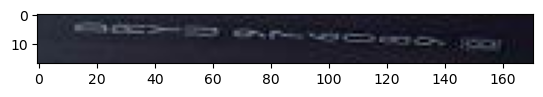

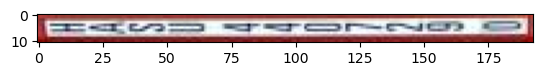

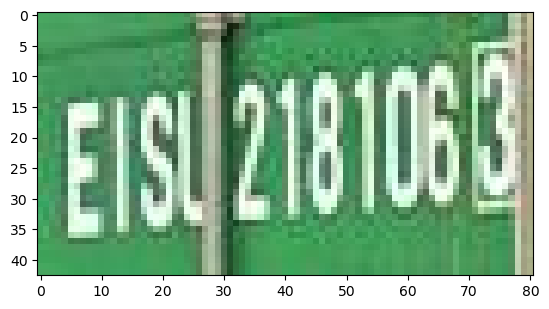

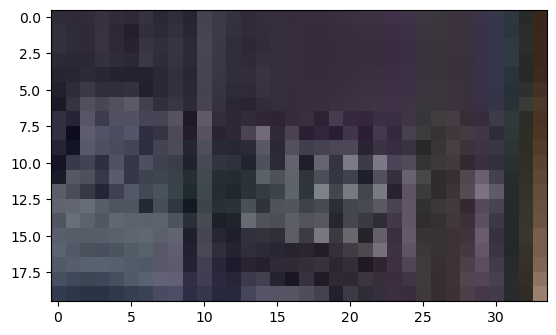

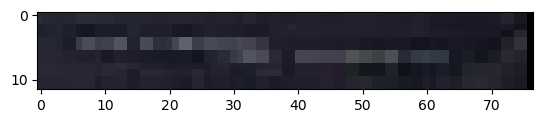

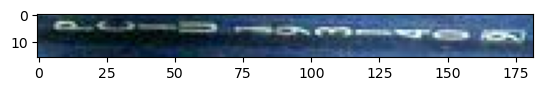

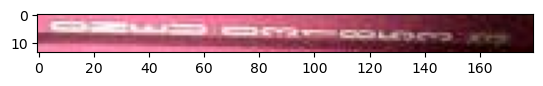

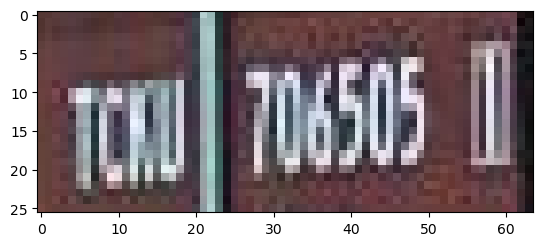

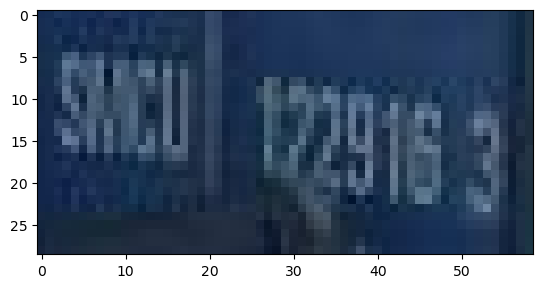

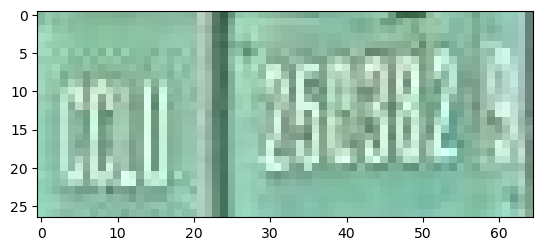

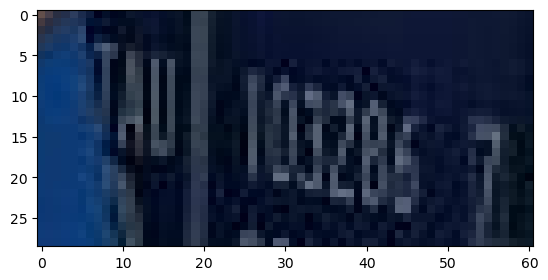

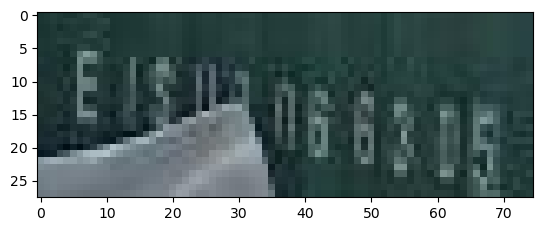

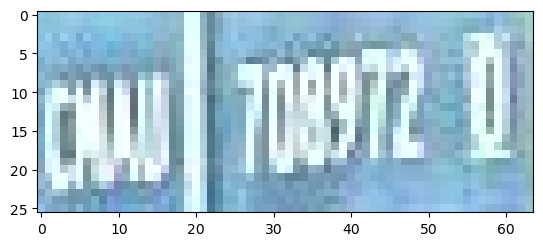

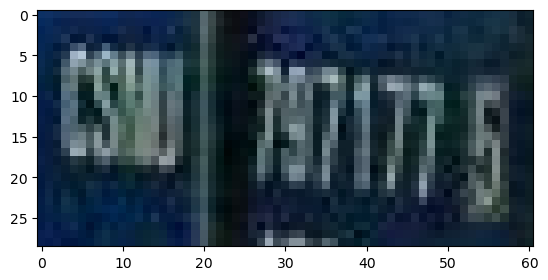

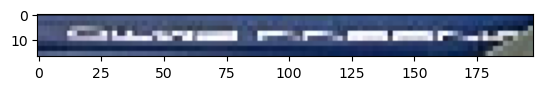

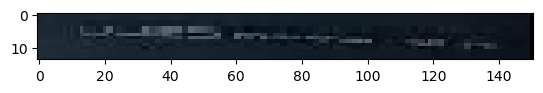

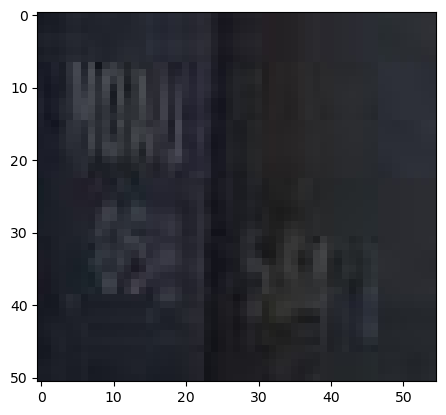

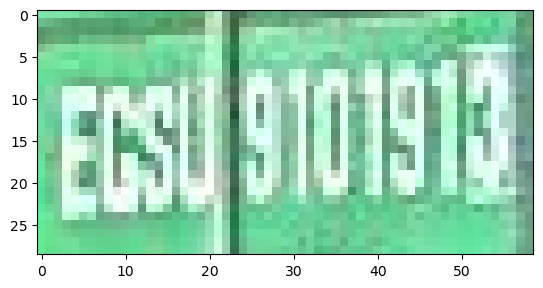

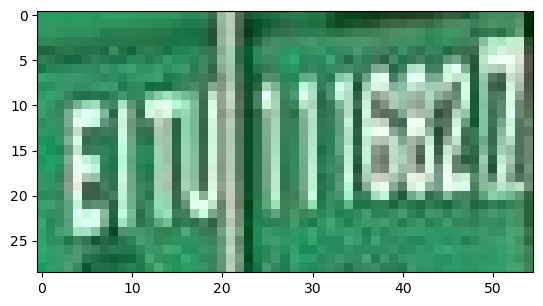

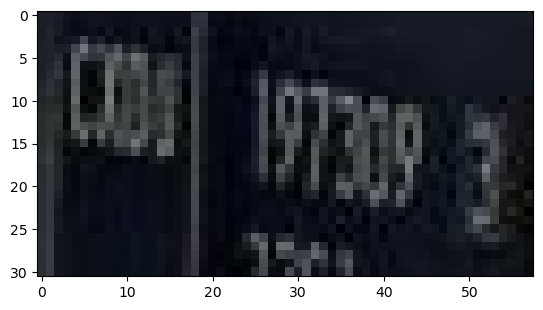

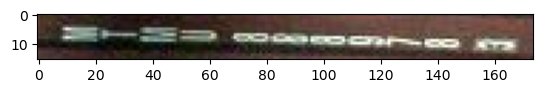

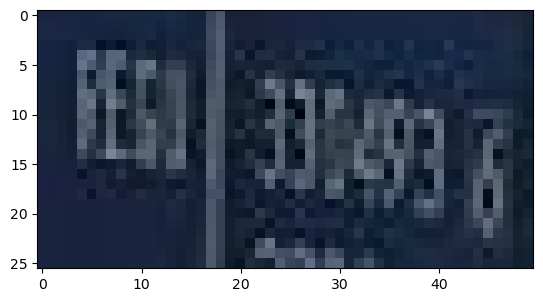

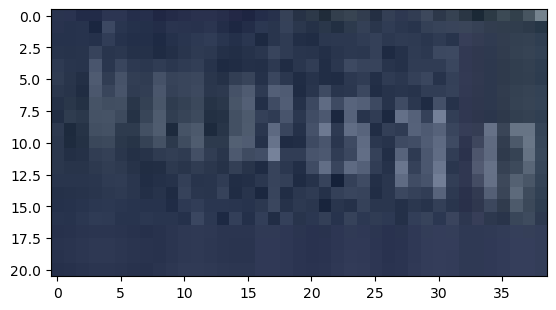

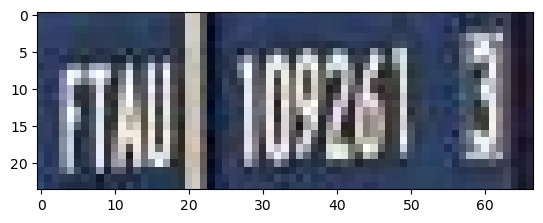

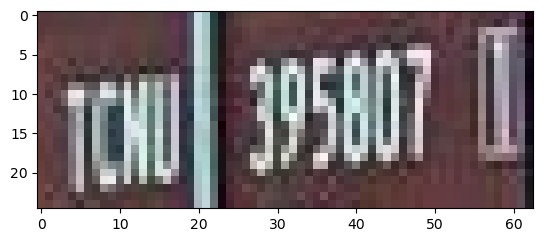

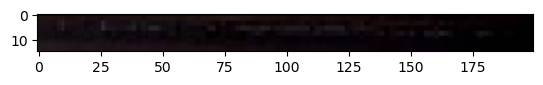

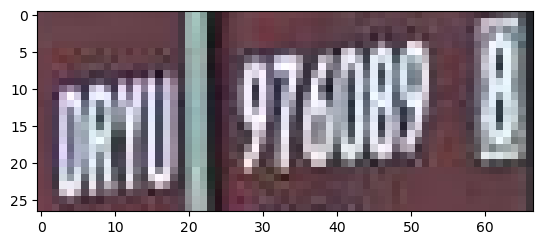

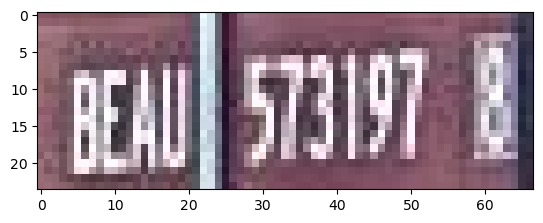

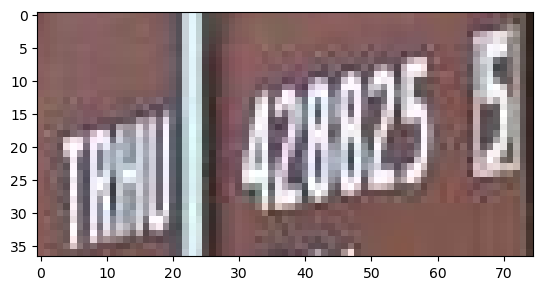

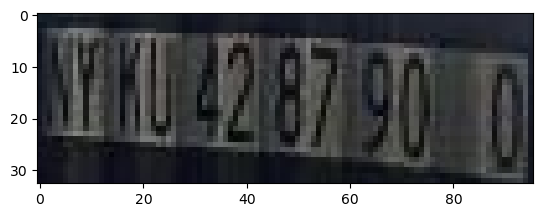

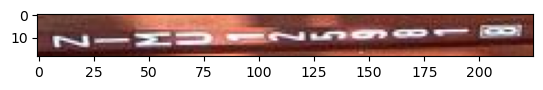

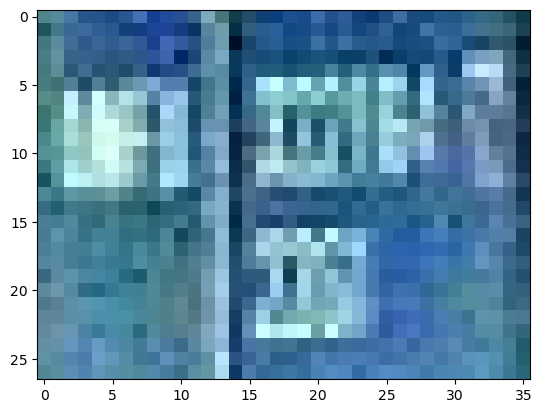

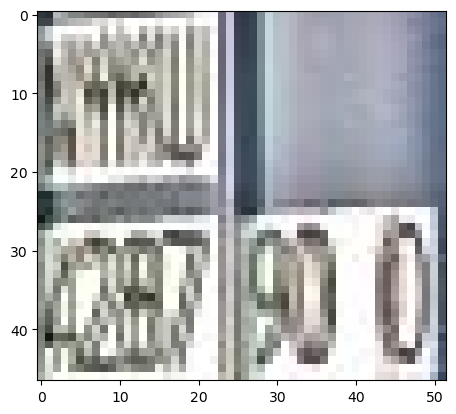

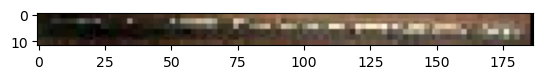

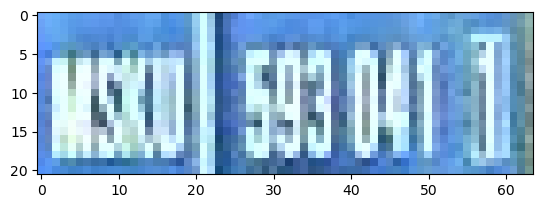

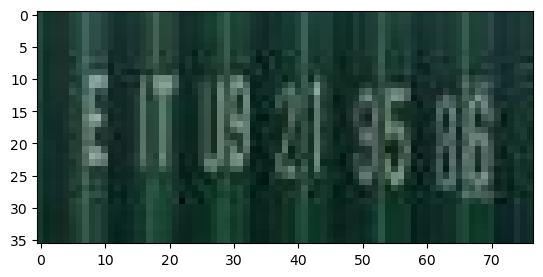

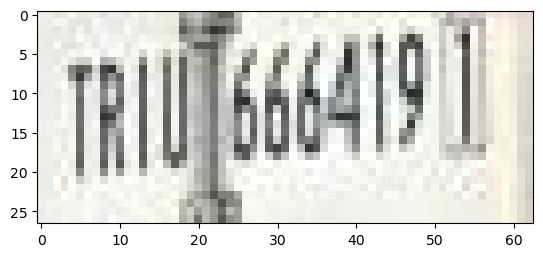

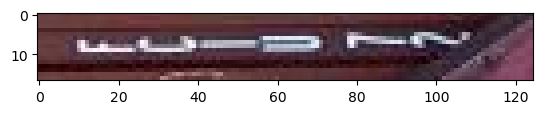

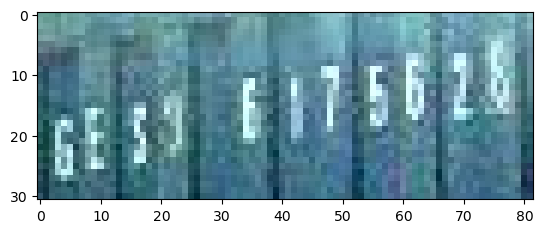

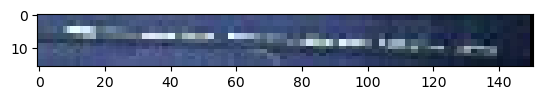

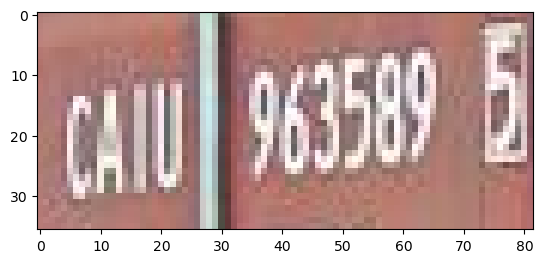

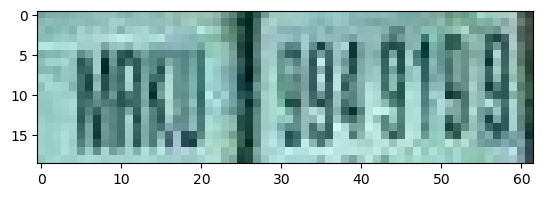

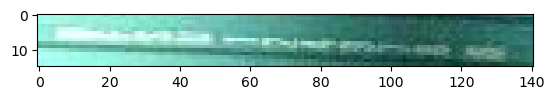

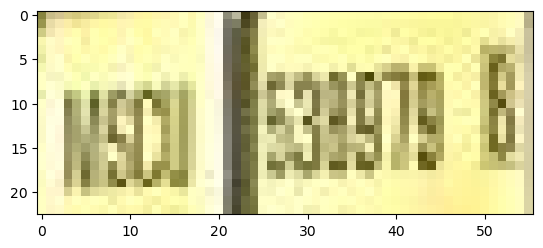

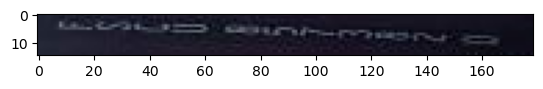

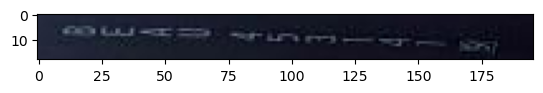

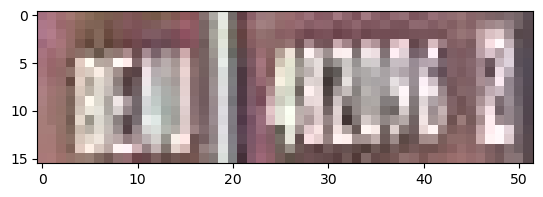

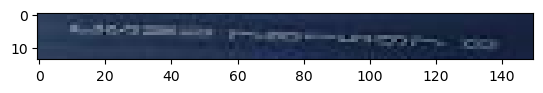

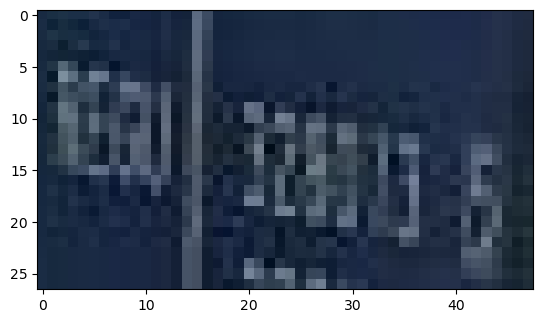

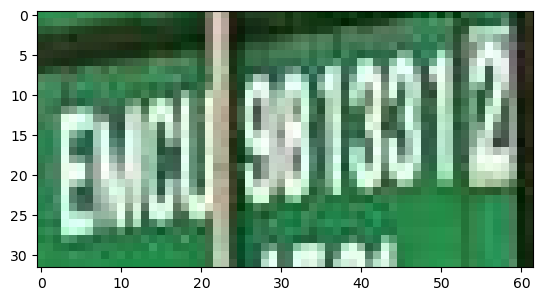

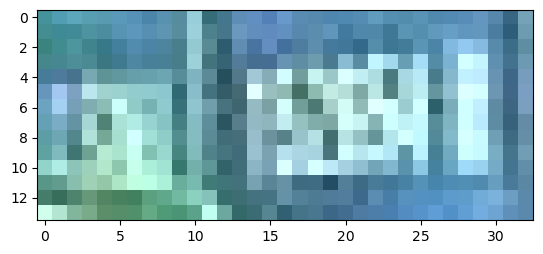

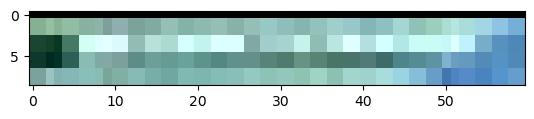

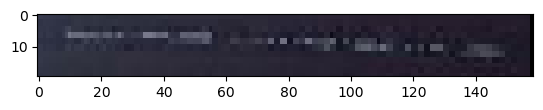

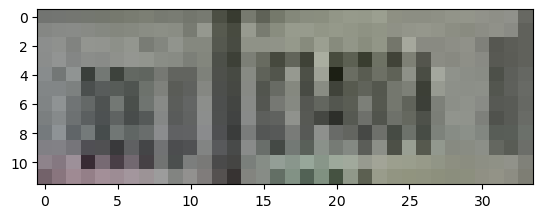

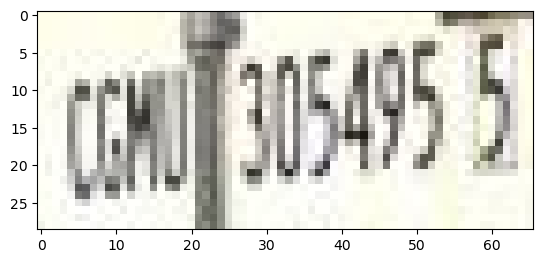

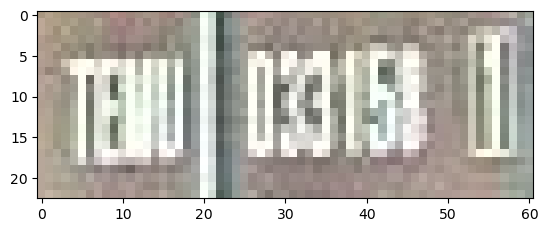

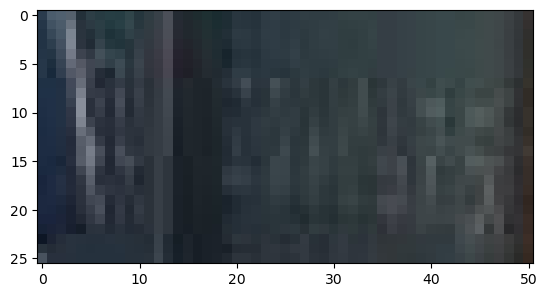

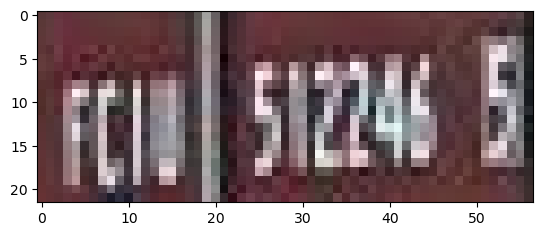

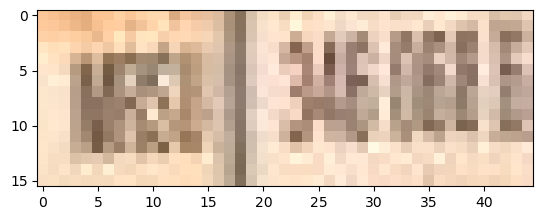

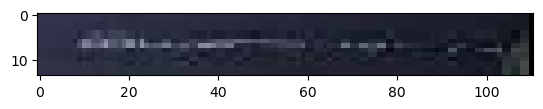

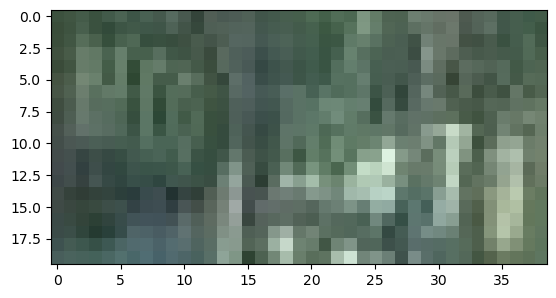

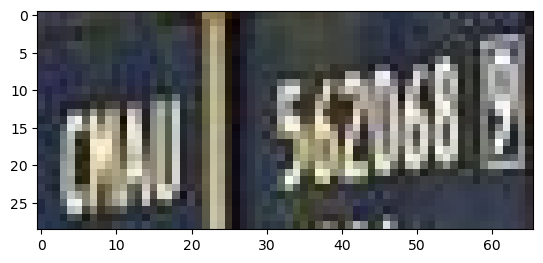

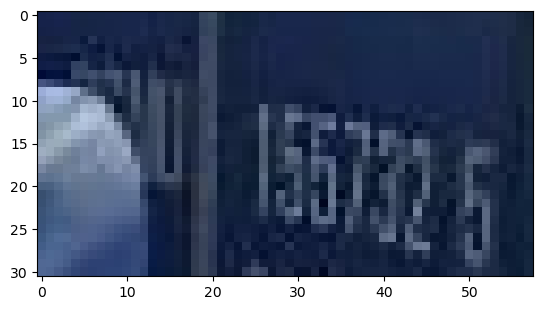

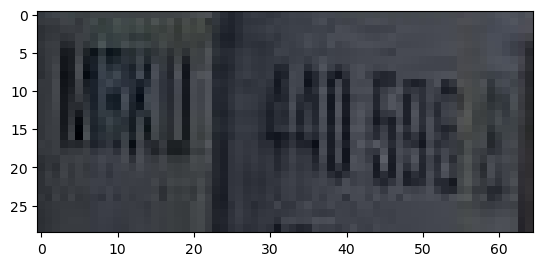

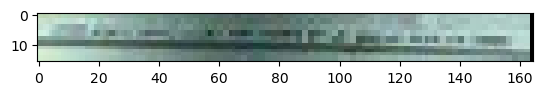

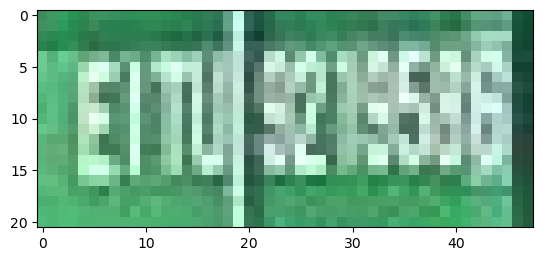

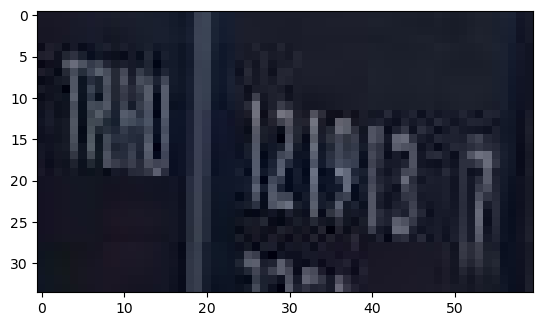

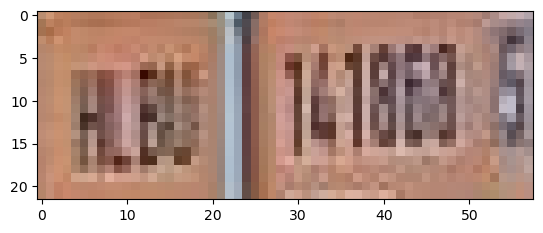

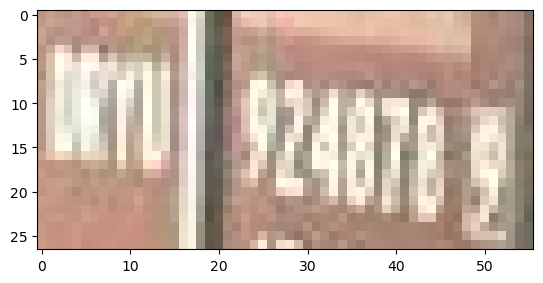

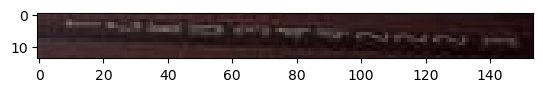

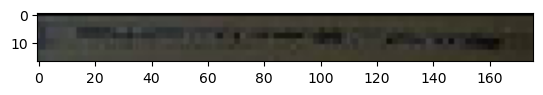

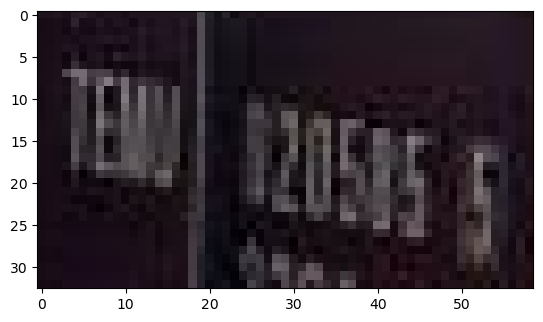

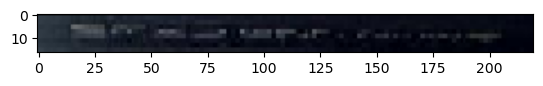

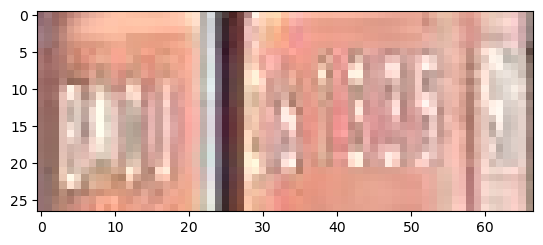

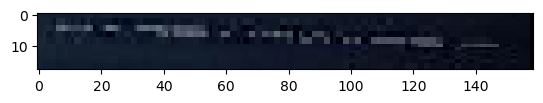

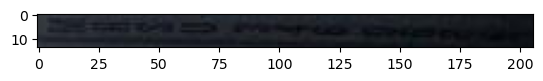

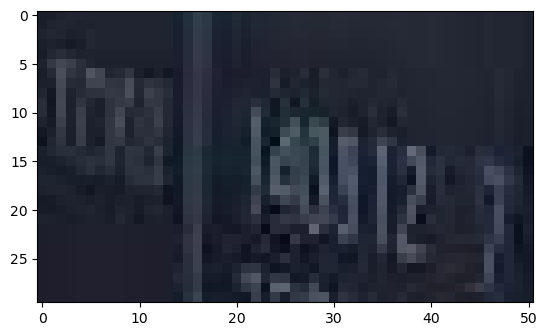

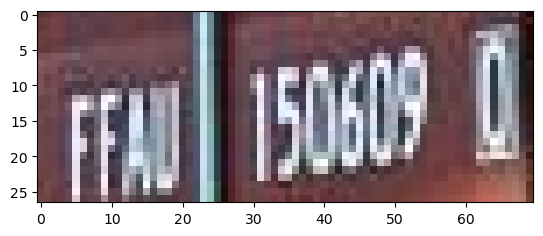

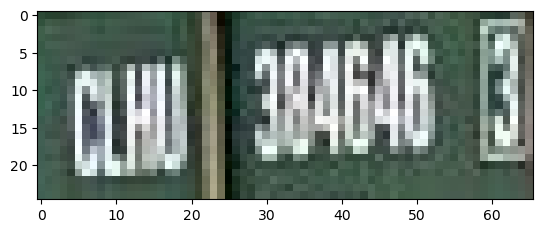

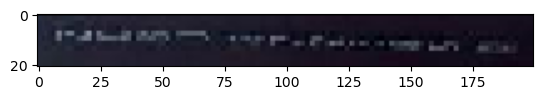

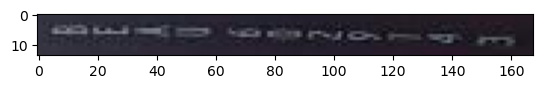

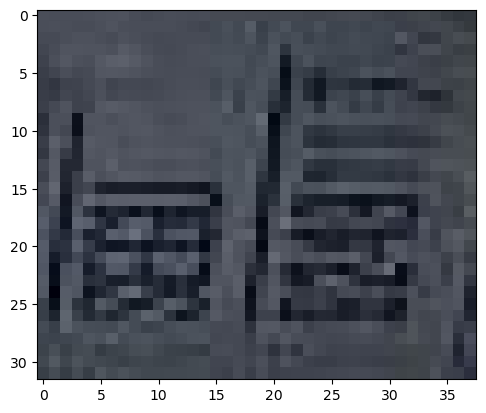

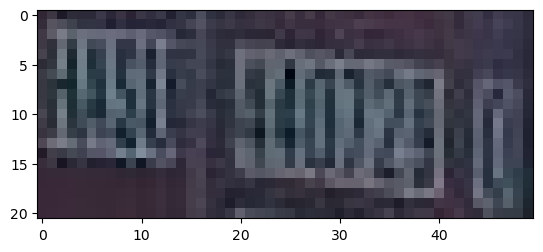

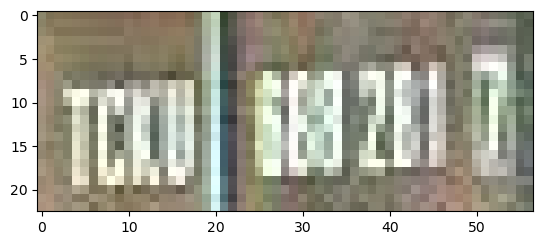

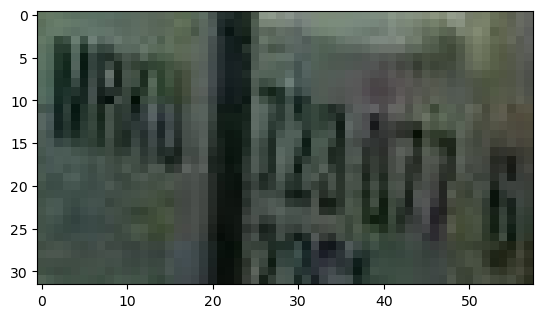

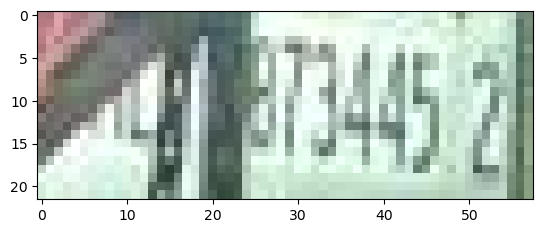

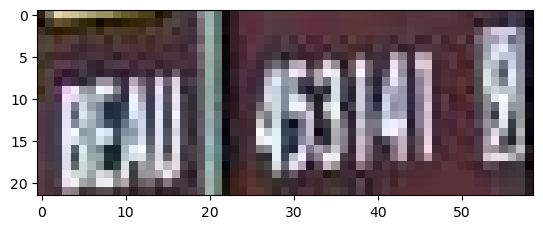

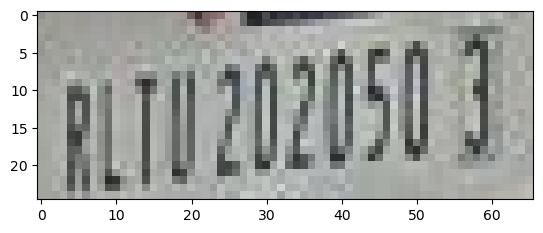

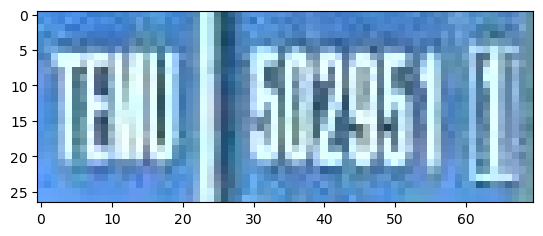

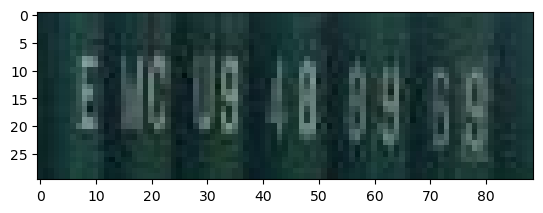

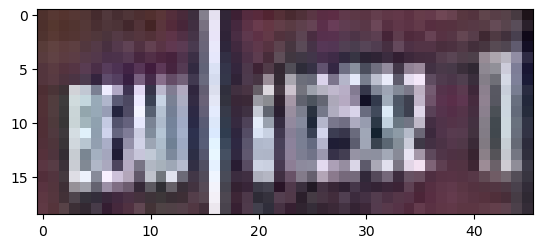

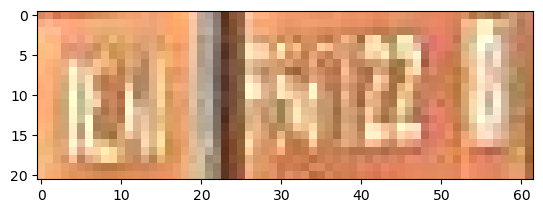

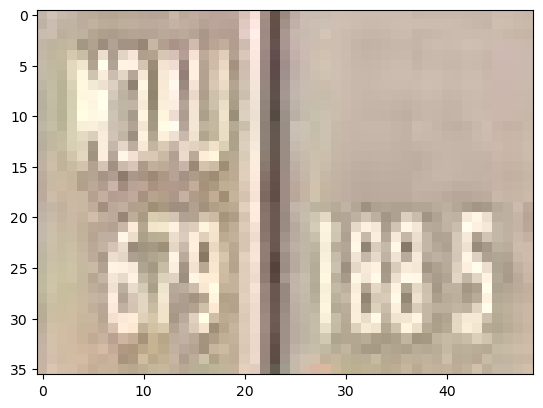

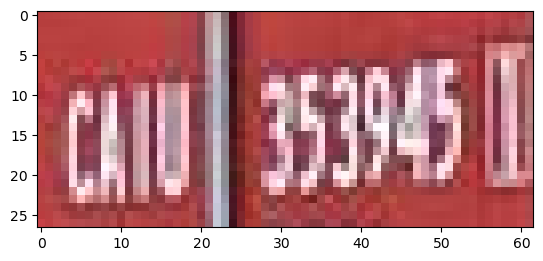

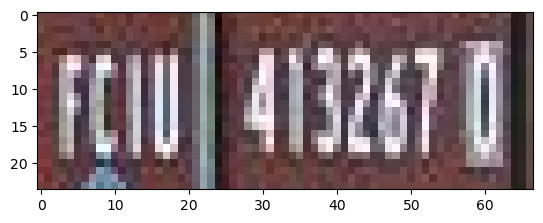

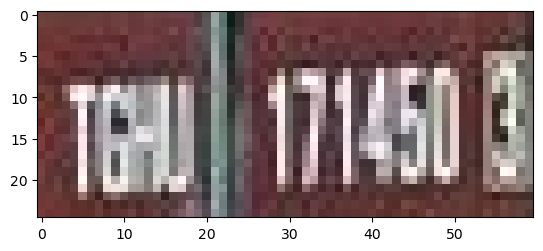

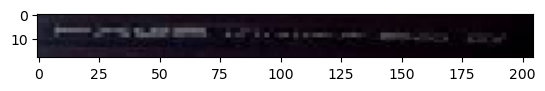

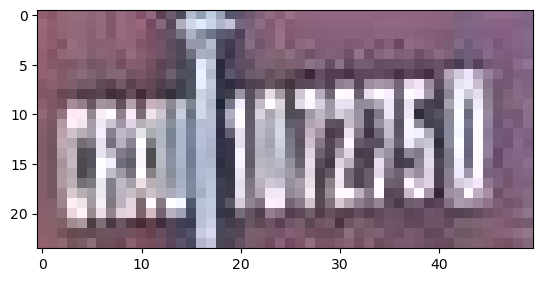

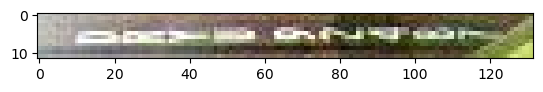

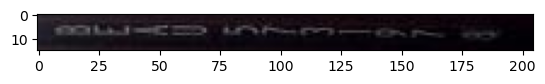

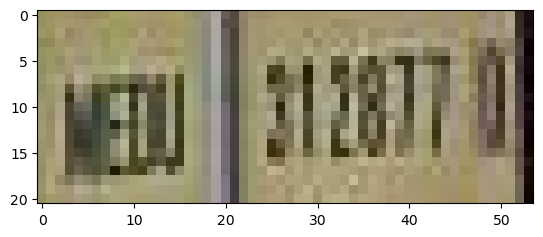

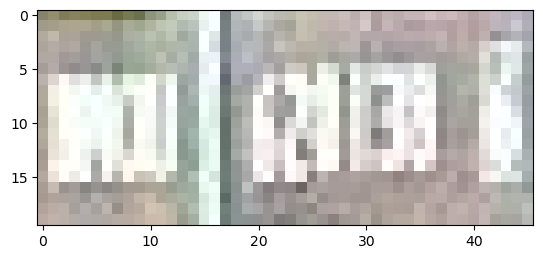

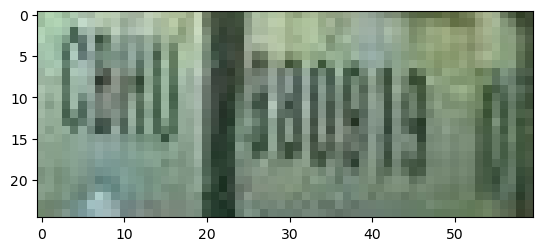

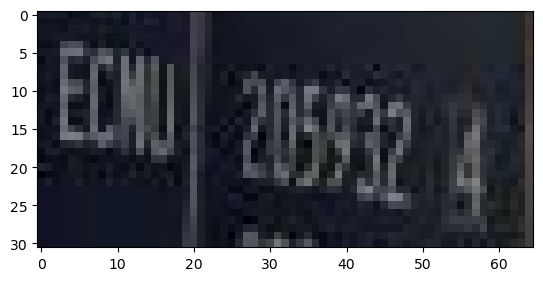

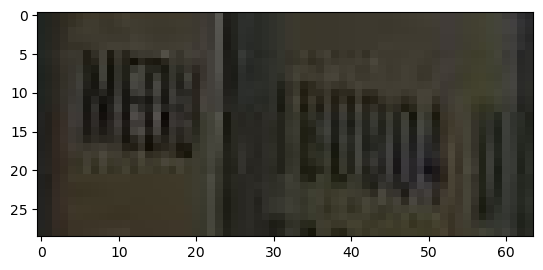

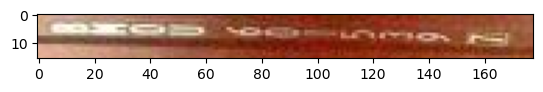

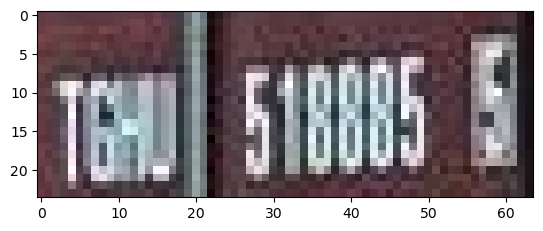

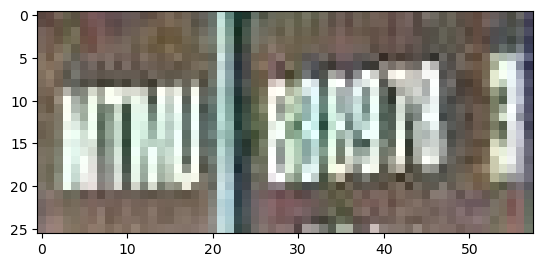

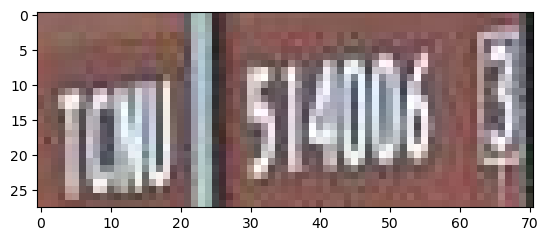

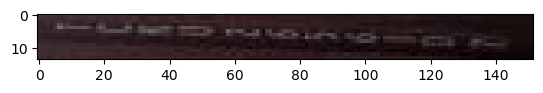

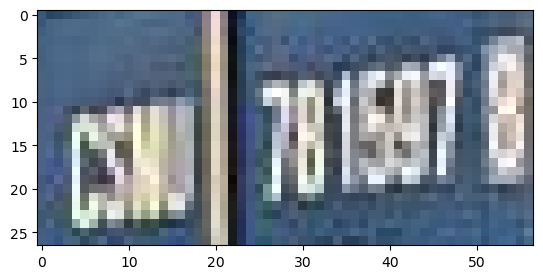

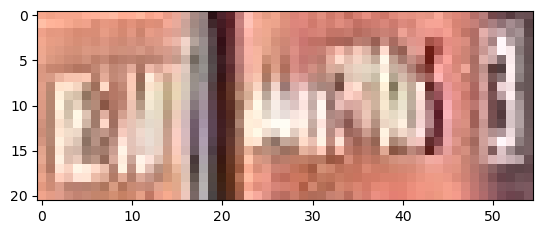

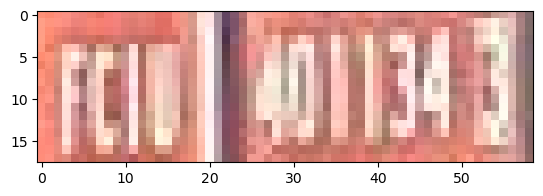

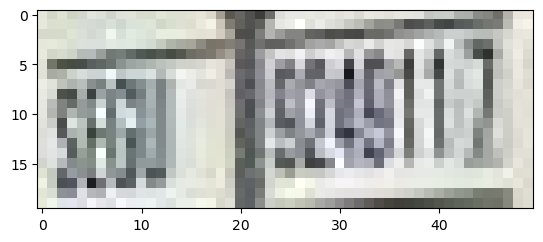

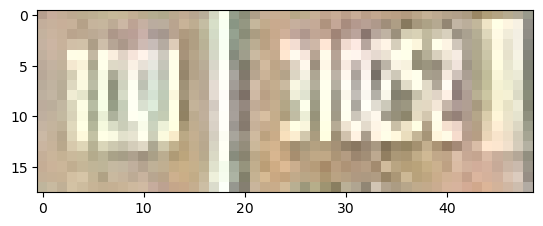

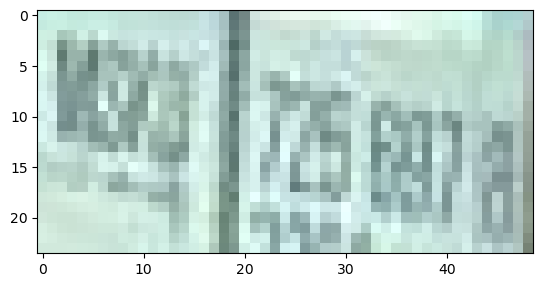

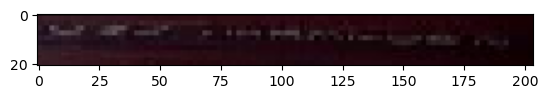

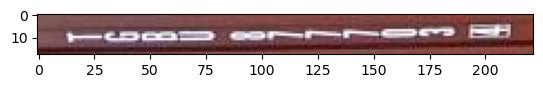

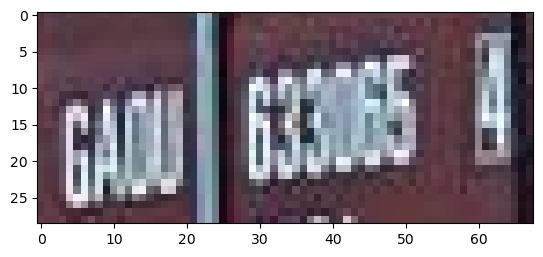

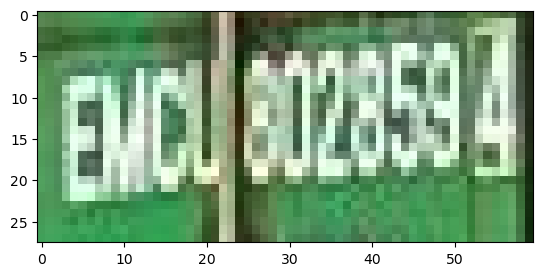

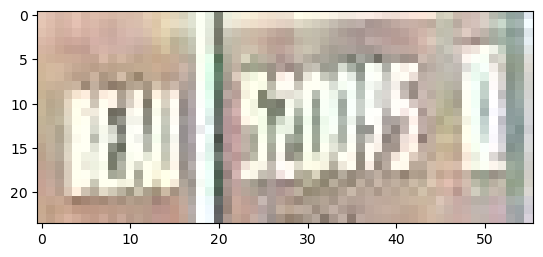

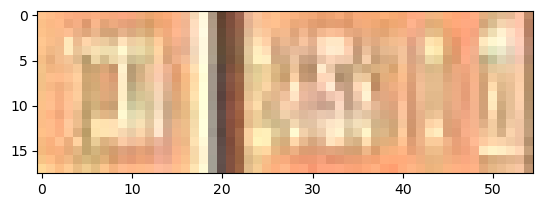

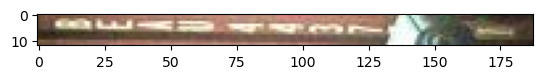

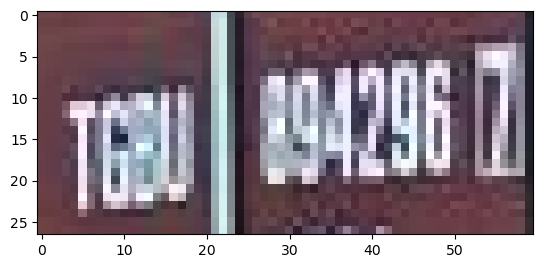

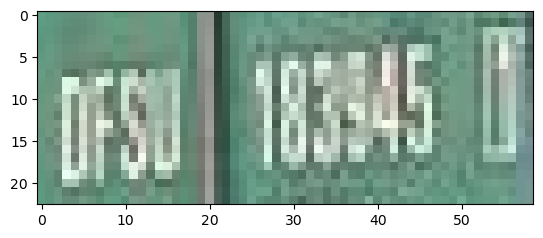

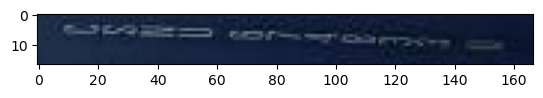

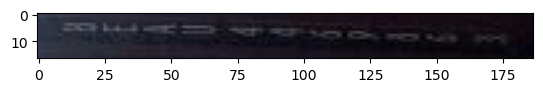

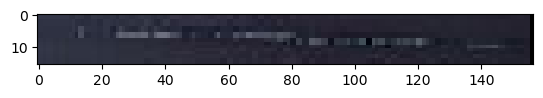

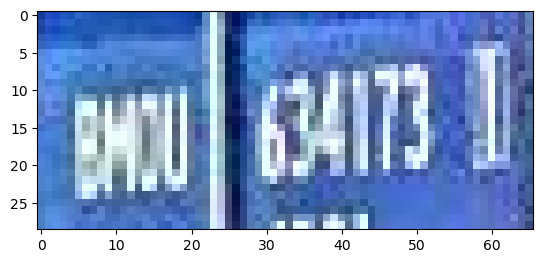

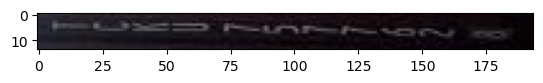

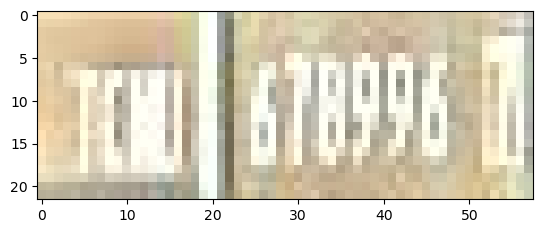

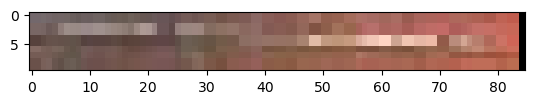

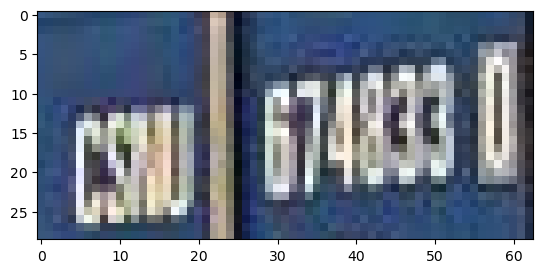

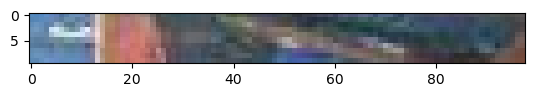

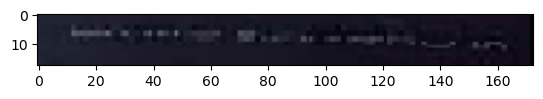

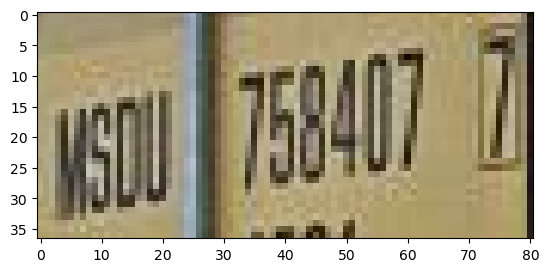

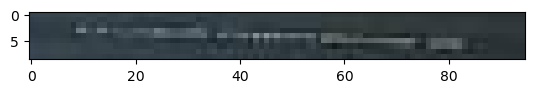

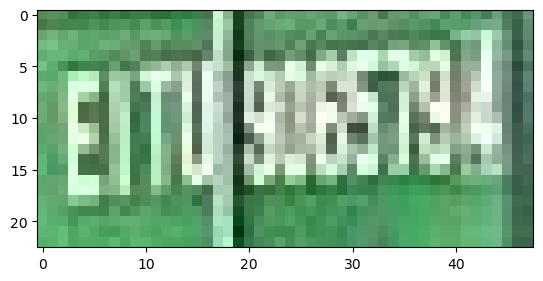

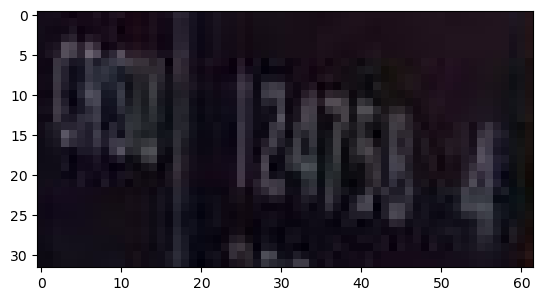

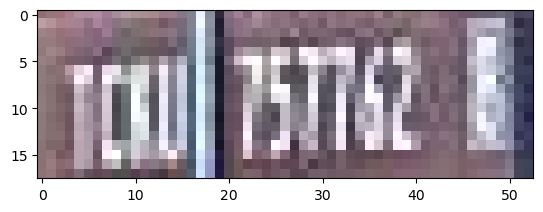

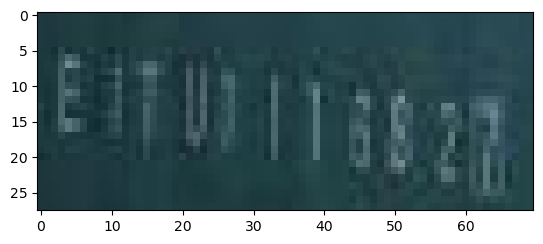

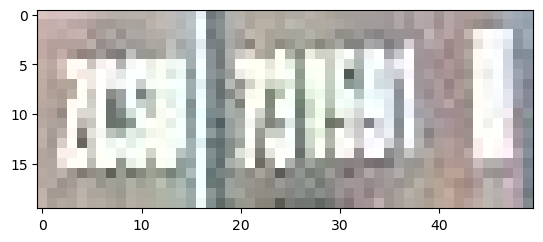

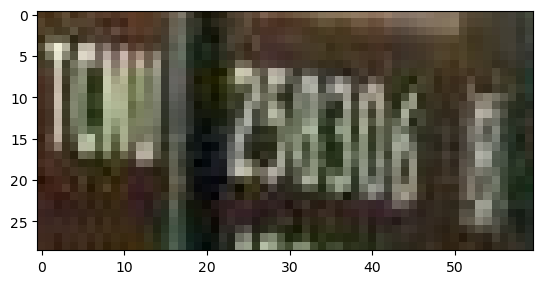

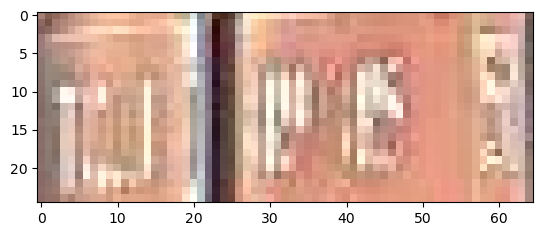

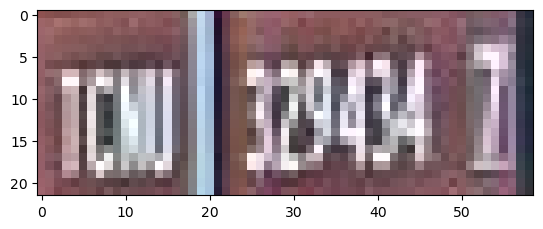

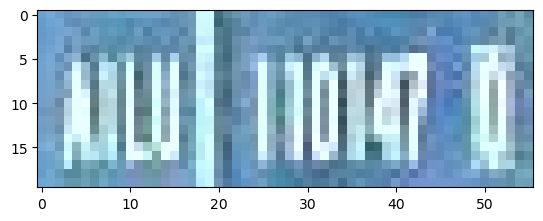

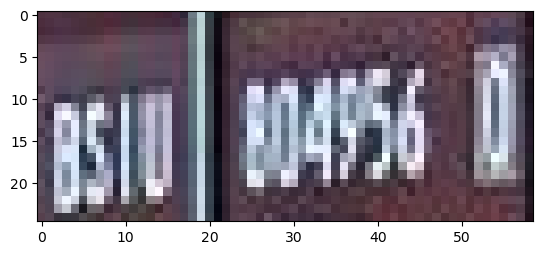

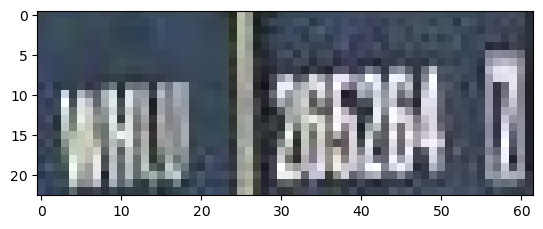

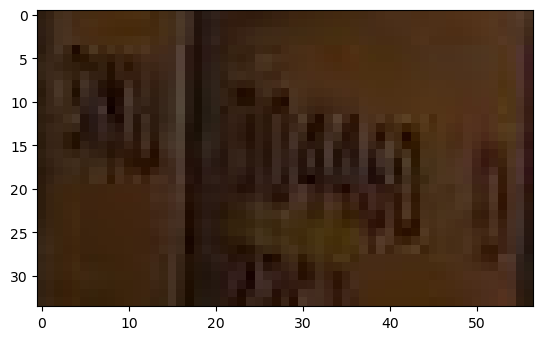

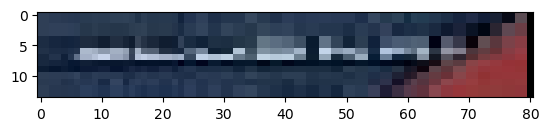

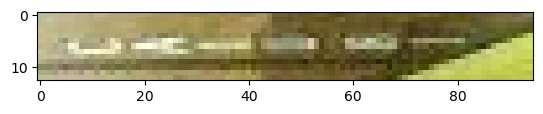

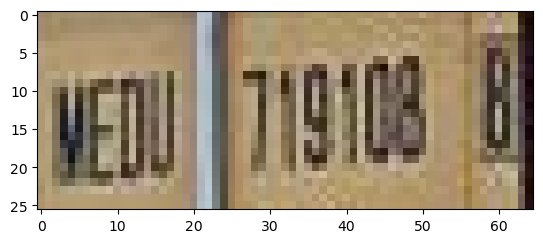

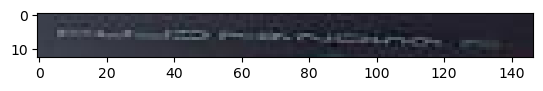

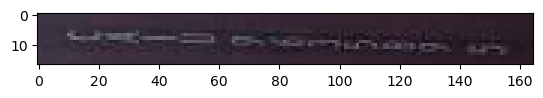

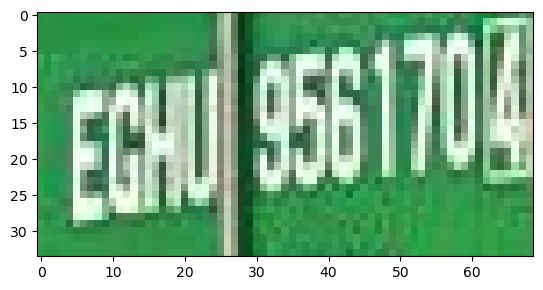

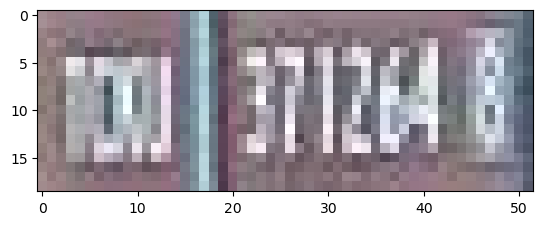

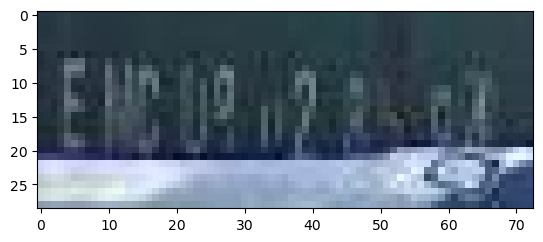

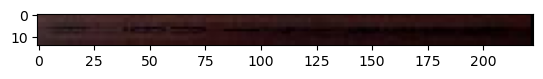

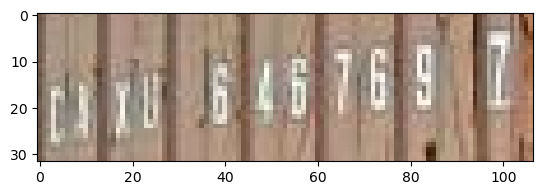

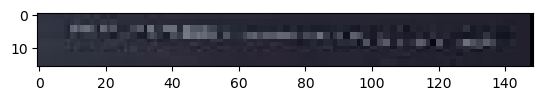

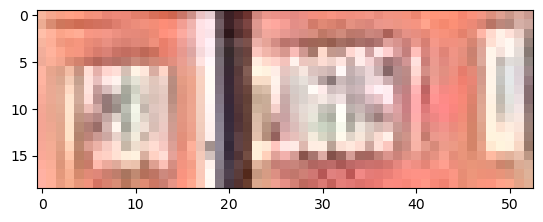

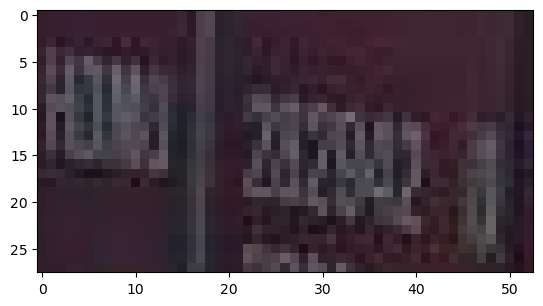

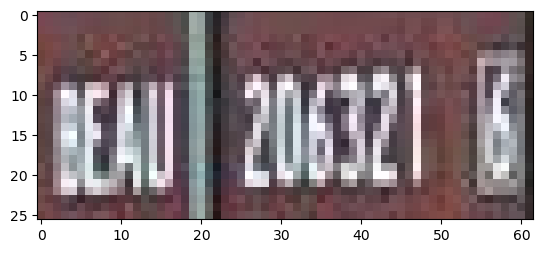

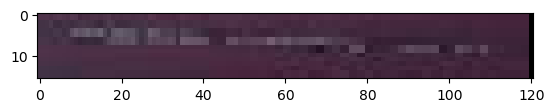

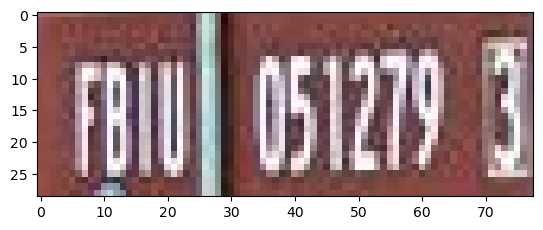

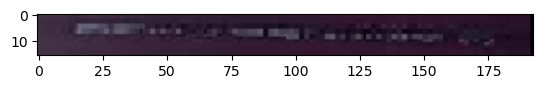

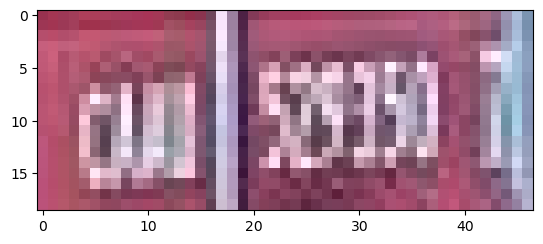

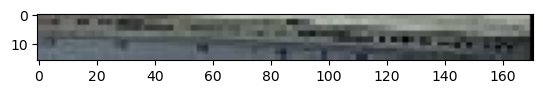

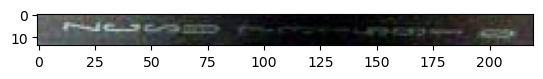

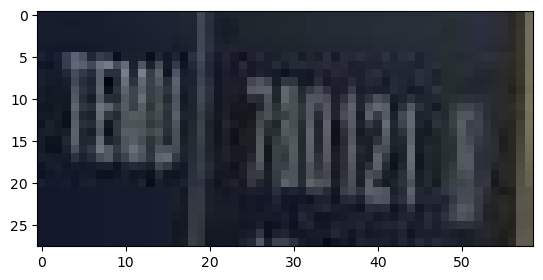

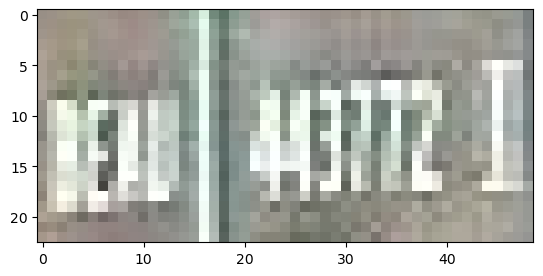

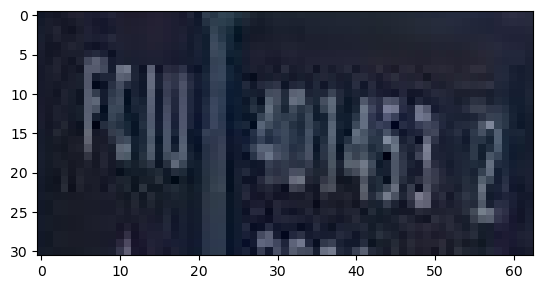

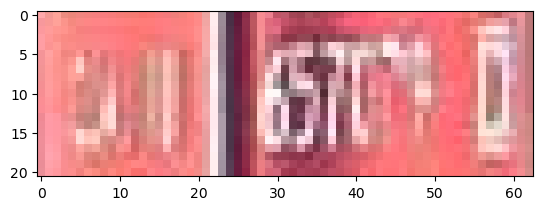

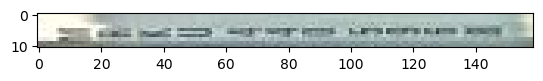

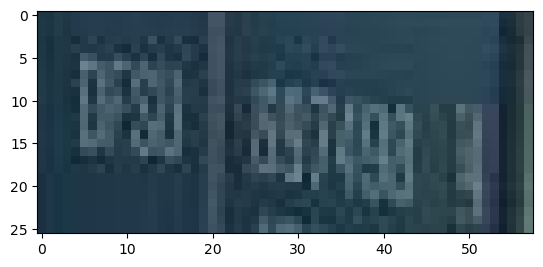

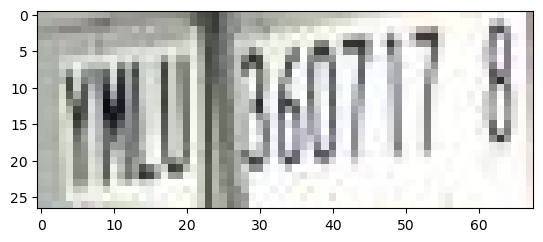

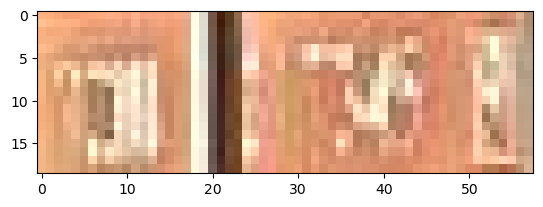

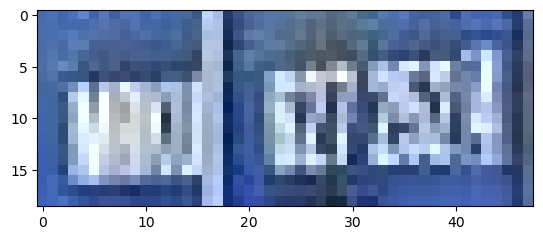

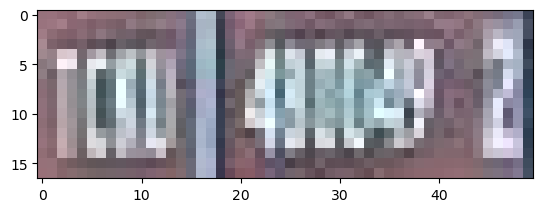

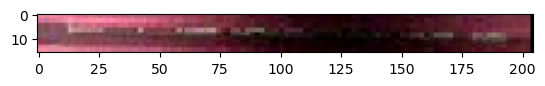

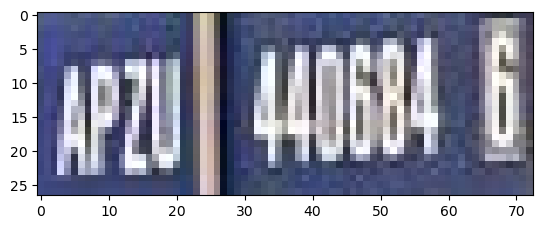

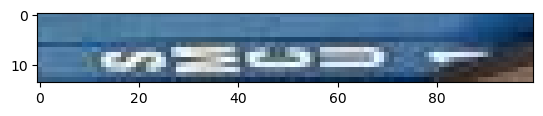

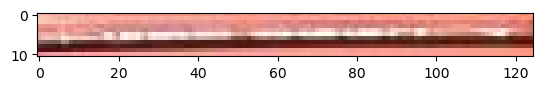

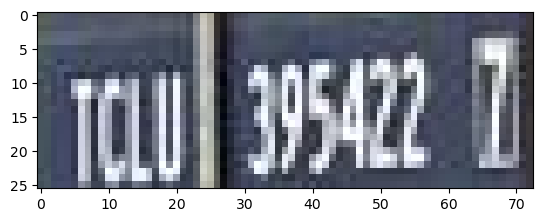

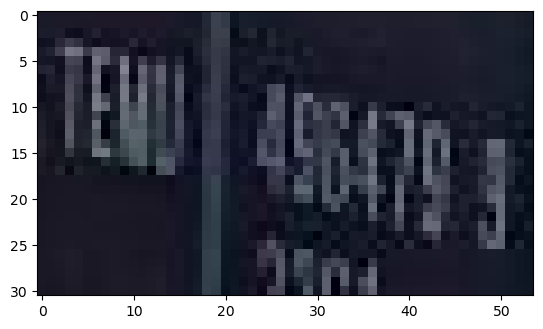

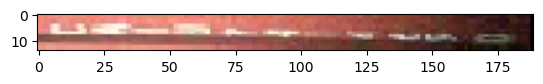

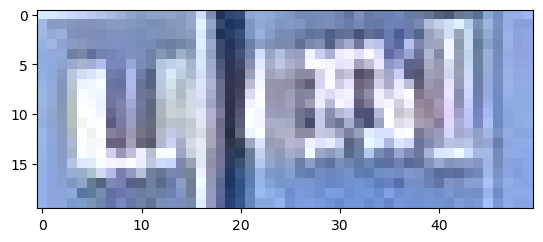

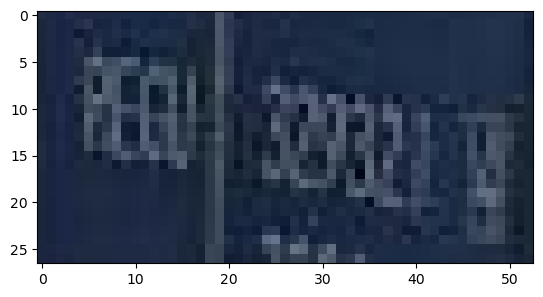

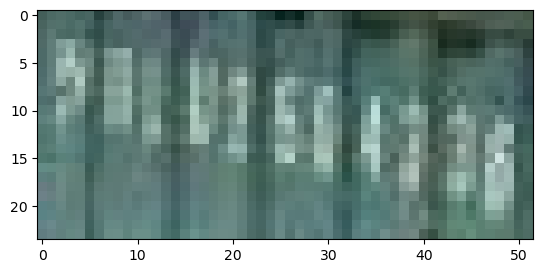

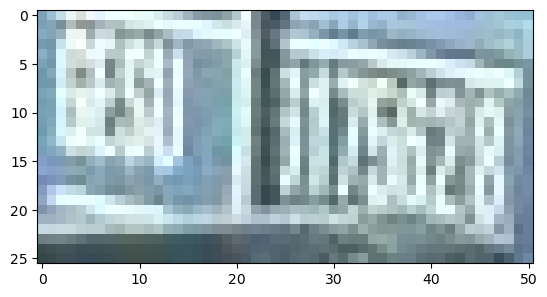

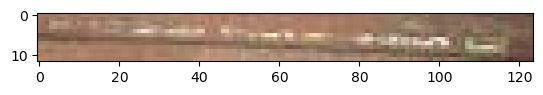

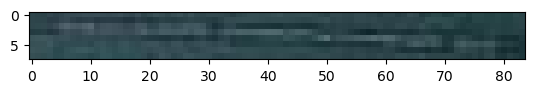

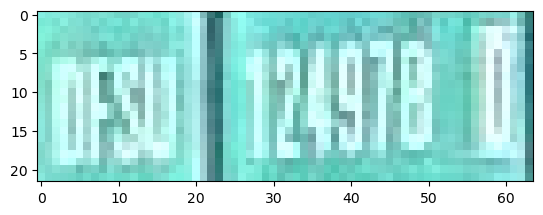

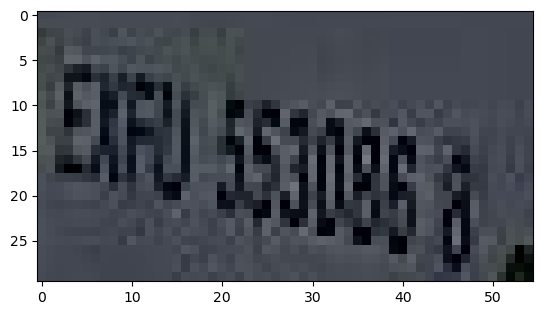

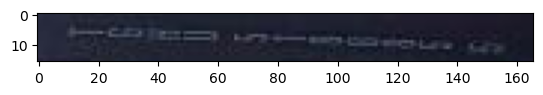

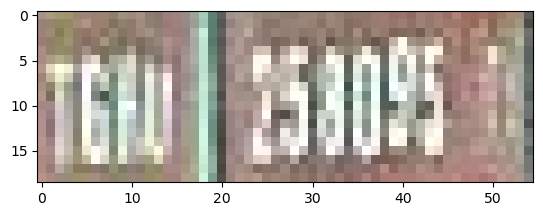

In [9]:
dataset = ContainerOCRDatasetText('../../data/container_dataset/')
vertical_count = 0
horizontal_count = 0

for image, label in dataset:
    _, h, w = image.shape
    if h < w:
        plt.figure()
        plt.imshow(image.permute([1, 2, 0]))
        vertical_count += 1
    else:
        horizontal_count += 1

In [ ]:
device = torch.device("mps")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
ocrModel = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
ocrModel = ocrModel.to(device)

ocrModel.config.decoder_start_token_id = processor.tokenizer.cls_token_id
ocrModel.config.pad_token_id = processor.tokenizer.pad_token_id
ocrModel.config.eos_token_id = processor.tokenizer.sep_token_id
ocrModel.config.max_length = 10
ocrModel.config.no_repeat_ngram_size = 3
ocrModel.config.length_penalty = 2.0
ocrModel.config.num_beams = 4
optimizer = torch.optim.AdamW(ocrModel.parameters(), lr=5e-5)

In [ ]:
processor.tokenizer(['hello there', 'how are you'])

In [ ]:
processor(torch.randint(size=[3, 3, 256, 256], low=0, high=255))

In [ ]:
for sample in ContainerOCRDatasetText("container_dataset/", processor=processor):
    processed_image, image, label = sample[0], sample[-1], sample[1]

    if image.size(1) < image.size(2):
        continue

    fig, axes = plt.subplots(ncols=2)
    axes[1].imshow(torch.permute(image, [1, 2, 0]))
    axes[0].imshow(torch.permute(processed_image, [1, 2, 0]))

In [ ]:
# ocrModel.load_state_dict(torch.load('./data/model/33_model.pt', map_location=torch.device('cpu')))

In [ ]:
training_data = ContainerOCRDatasetText(
    directory="./container_dataset/",
    processor=processor,
    is_train=True,
)

train_dataloader = DataLoader(
    training_data,
    batch_size=1,
    shuffle=True,
)

test_data = ContainerOCRDatasetText(
    directory="./container_dataset/",
    processor=processor,
    is_train=False,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=5,
)

for sample in train_dataloader:
    print(sample[1][0])
    break

# for sample in train_dataloader:
#     plt.figure()
#     print(sample[0].size())
#     plt.imshow(torch.permute(sample[0].squeeze(), [1, 2, 0]).cpu().numpy())

# plt.figure()
# plt.imshow(torch.permute(sample[2].squeeze(), [1, 2, 0]).cpu().numpy())
# break

In [ ]:
cer_metric = load_metric("cer")


def compute_cer(pred_ids, label_ids):
    sum_cer = 0
    for pred, label in zip(pred_ids, label_ids):
        pred_str = processor.decode(pred, skip_special_tokens=True)
        label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
        label_str = processor.decode(label, skip_special_tokens=True)
        print(f'"{label_str}"  "{pred_str}"')

        if pred_str == "":
            sum_cer += len(label_str)
        elif label_str == "":
            sum_cer += len(pred_str)
        else:
            sum_cer += cer_metric.compute(
                predictions=[pred_str], references=[label_str]
            )
        print(sum_cer)
    return sum_cer / len(pred_ids)

In [ ]:
for epoch in range(0, 200):
    # train_running_loss = 0.0
    # ocrModel.train()
    # for idx, data in enumerate(tqdm(train_dataloader)):

    #     inputs: torch.Tensor
    #     labels: torch.Tensor
    #     inputs, labels = data[0], data[1]

    #     inputs = inputs.to(device)
    #     labels = labels.to(device)

    #     output = ocrModel(inputs, labels=labels)
    #     output.loss.backward()
    #     train_running_loss += output.loss.item()
    #     optimizer.step()
    #     optimizer.zero_grad()

    validation_cer = 0
    ocrModel.eval()
    for data in test_dataloader:
        with torch.no_grad():
            inputs: torch.Tensor
            labels: torch.Tensor
            inputs, labels = data[0], data[1]

            inputs = inputs.to(device)
            labels = labels.to(device)

            generated_ids = ocrModel.generate(inputs)

            cer = compute_cer(generated_ids, labels)
            validation_cer += cer
    print(validation_cer / len(test_dataloader))

In [ ]:
test_data = ContainerOCRDatasetText(
    directory="./container_dataset/",
    processor=processor,
    is_train=False,
)

for idx, sample in enumerate(test_data):
    with torch.no_grad():
        plt.figure()
        plt.imshow(torch.permute(sample[0], dims=[1, 2, 0]))

        sample[1][sample[1] == -100] = processor.tokenizer.pad_token_id
        generated_ids = ocrModel.generate(sample[0].to("mps").unsqueeze(dim=0))
        generated_text = processor.batch_decode(
            generated_ids, skip_special_tokens=True
        )[0]
        print(generated_text, processor.decode(sample[1], skip_special_tokens=True))

    if idx == 0:
        break